# Correlation between Sharma models and sPlot

In [1]:
from src.conf.conf import get_config


cfg = get_config()

In [2]:
import pandas as pd

pred = (
    pd.read_csv(
        "/mnt/gsdata/projects/panops/inferenceresult_withtaxa.csv", index_col=0
    ).drop(
        columns=[
            "image",
            "pft",
            "Species",
            "Kingdom",
            "Phylum",
            "Class",
            "Order",
            "Family",
            "Genus",
        ]
    )
    .reset_index(drop=True)
)

pred.head()

,latitude,longitude,X11_true,X50_true,X13_true,X47_true,X18_true,X3113_true,X46_true,X21_true,X11_pred,X50_pred,X13_pred,X47_pred,X18_pred,X3113_pred,X46_pred,X21_pred
0,34.04164,-118.75382,6.658405,3.087923,487.27390,0.343530,4.267365,404.27290,0.363895,0.559313,4.649353,5.344338,483.35428,0.348799,3.468139,133.96999,0.541114,0.913209
1,30.56922,-94.94951,40.300087,0.640547,452.35650,0.107740,0.113465,259.15524,0.193335,0.001461,54.065470,0.397057,442.75275,0.078284,0.140406,233.13930,0.165506,0.001030
2,38.64312,-122.77681,18.024319,1.873441,434.02188,0.177487,0.347974,2972.36280,0.246529,0.003411,20.772749,1.342314,426.17280,0.170424,0.220198,288.62753,0.259712,0.004816
3,40.96367,-81.33122,14.628735,0.916192,415.22140,0.267856,0.214478,331.35138,0.173195,0.008341,20.374573,1.060553,399.09528,0.217466,0.330928,303.52582,0.185314,0.010413
4,32.99591,-96.62907,19.042921,1.842616,464.56600,0.241688,0.352798,1817.61940,0.208809,0.026467,21.970524,1.654610,459.28067,0.208234,0.234546,865.43070,0.218797,0.011382


/tmp/ipykernel_1258506/2258739677.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(20, 10))


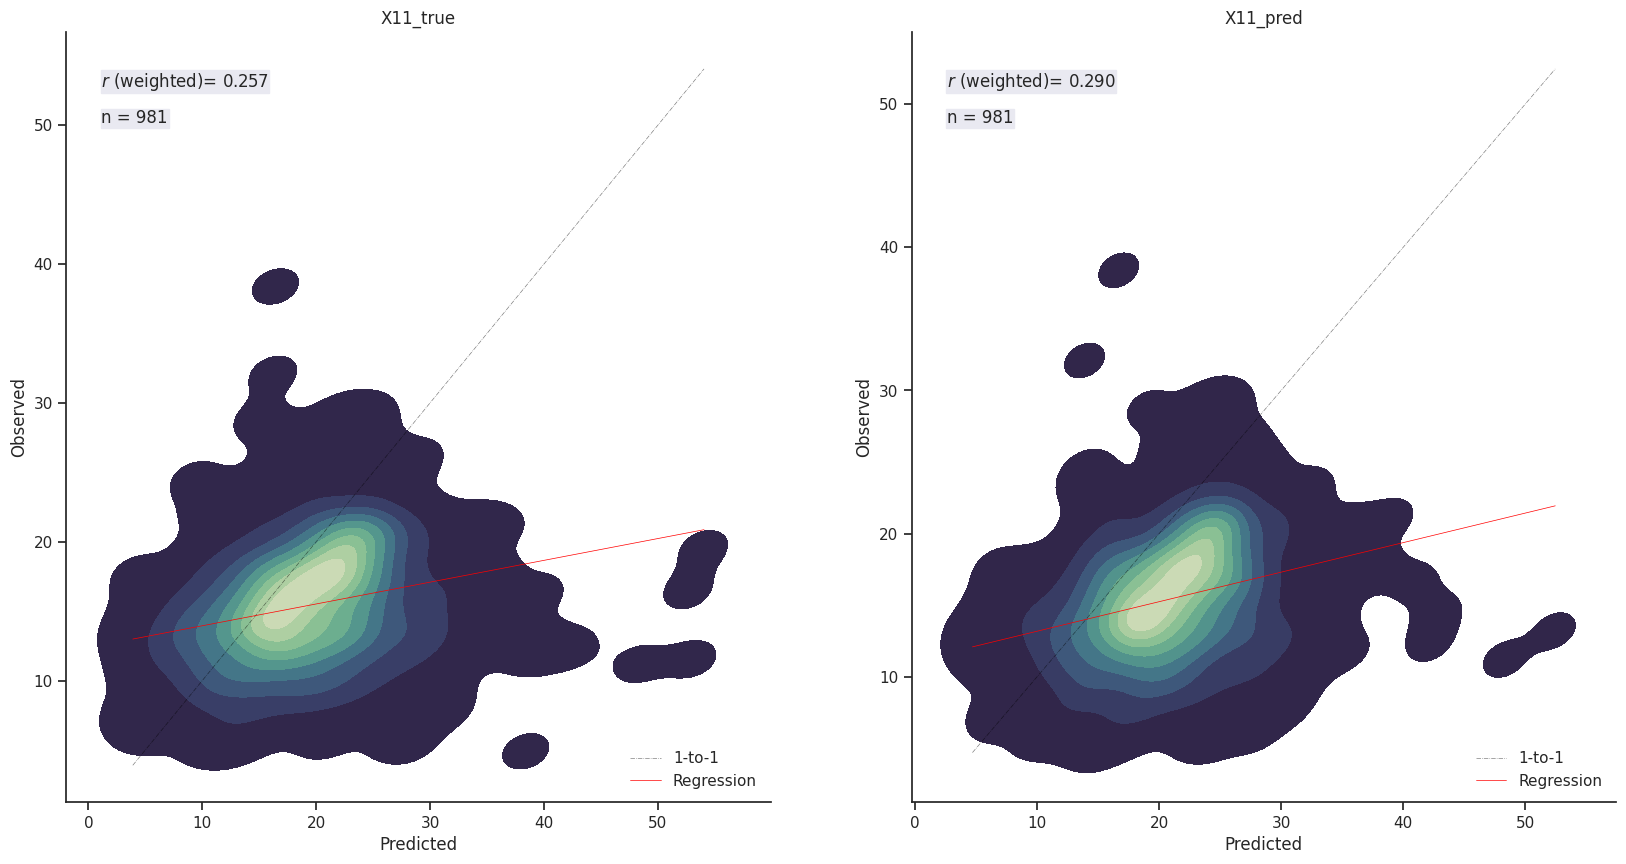

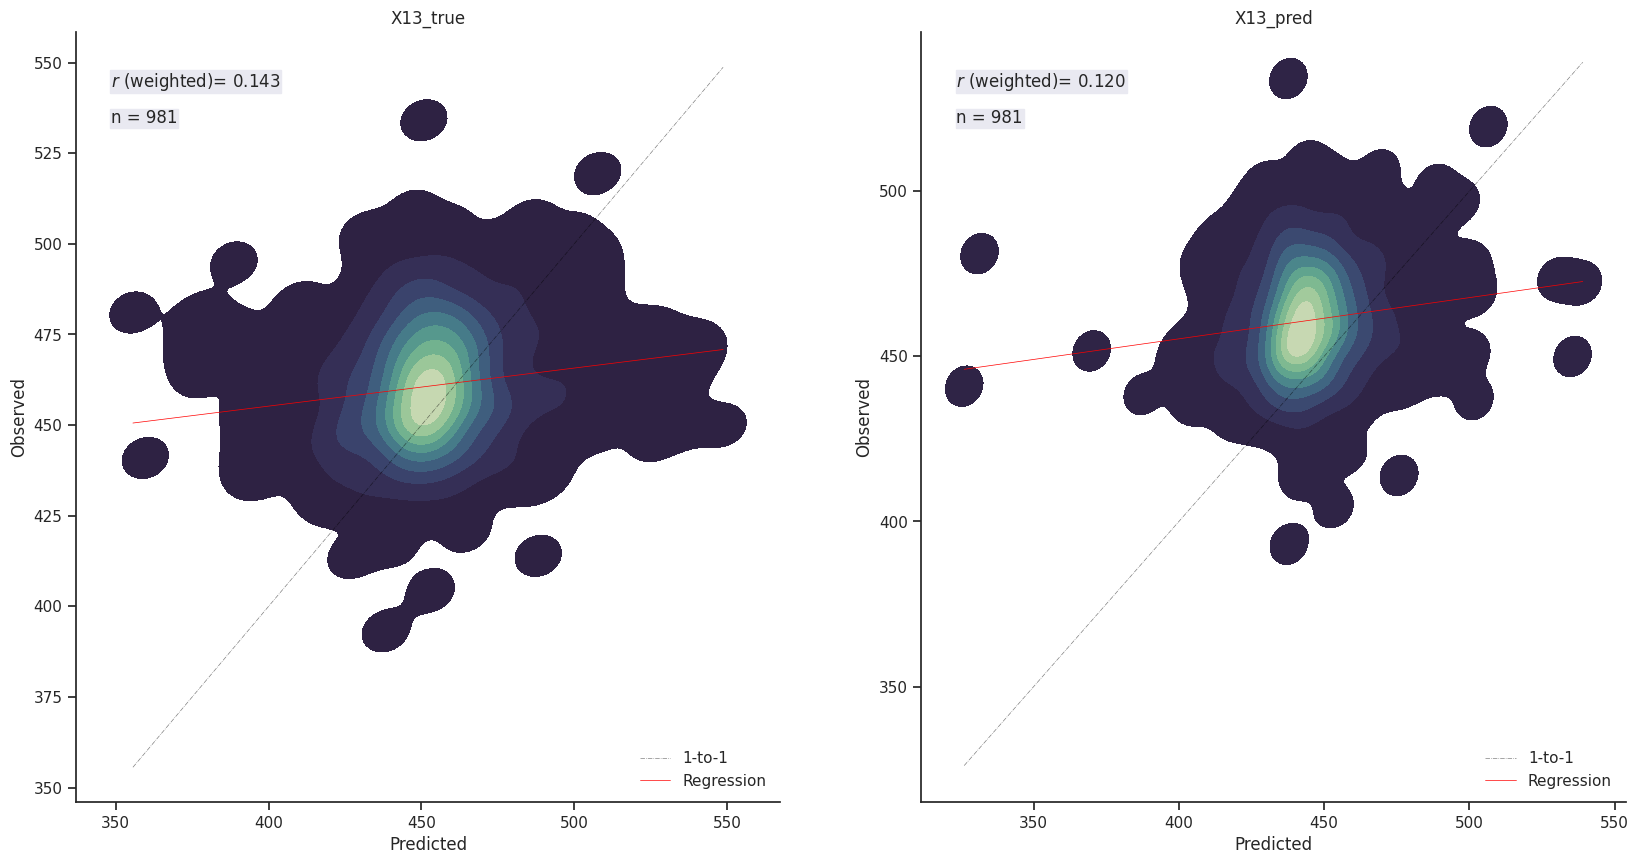

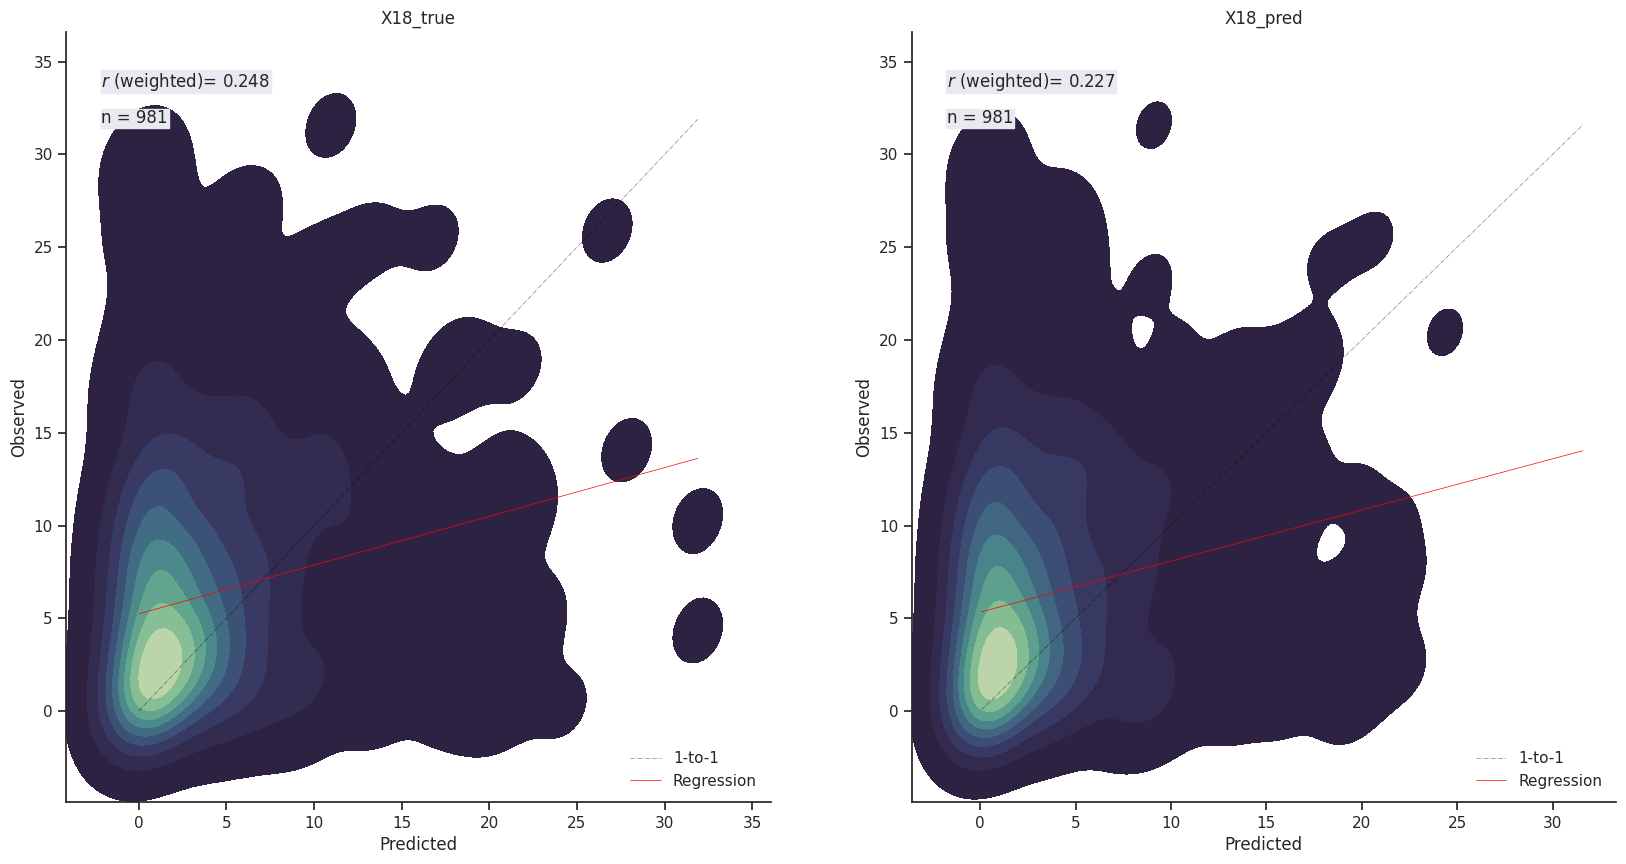

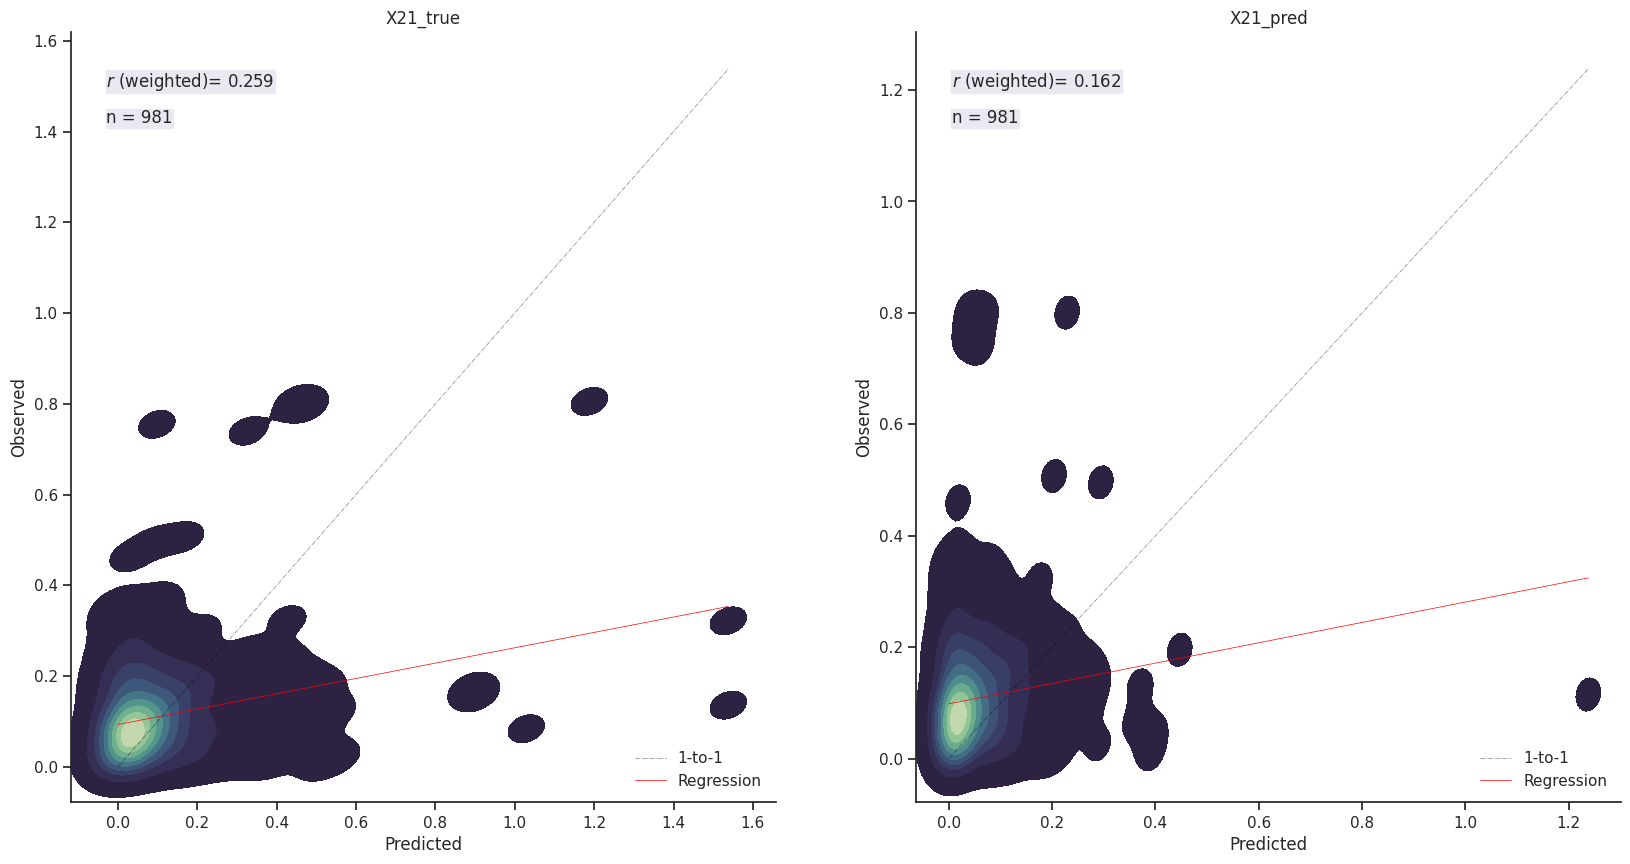

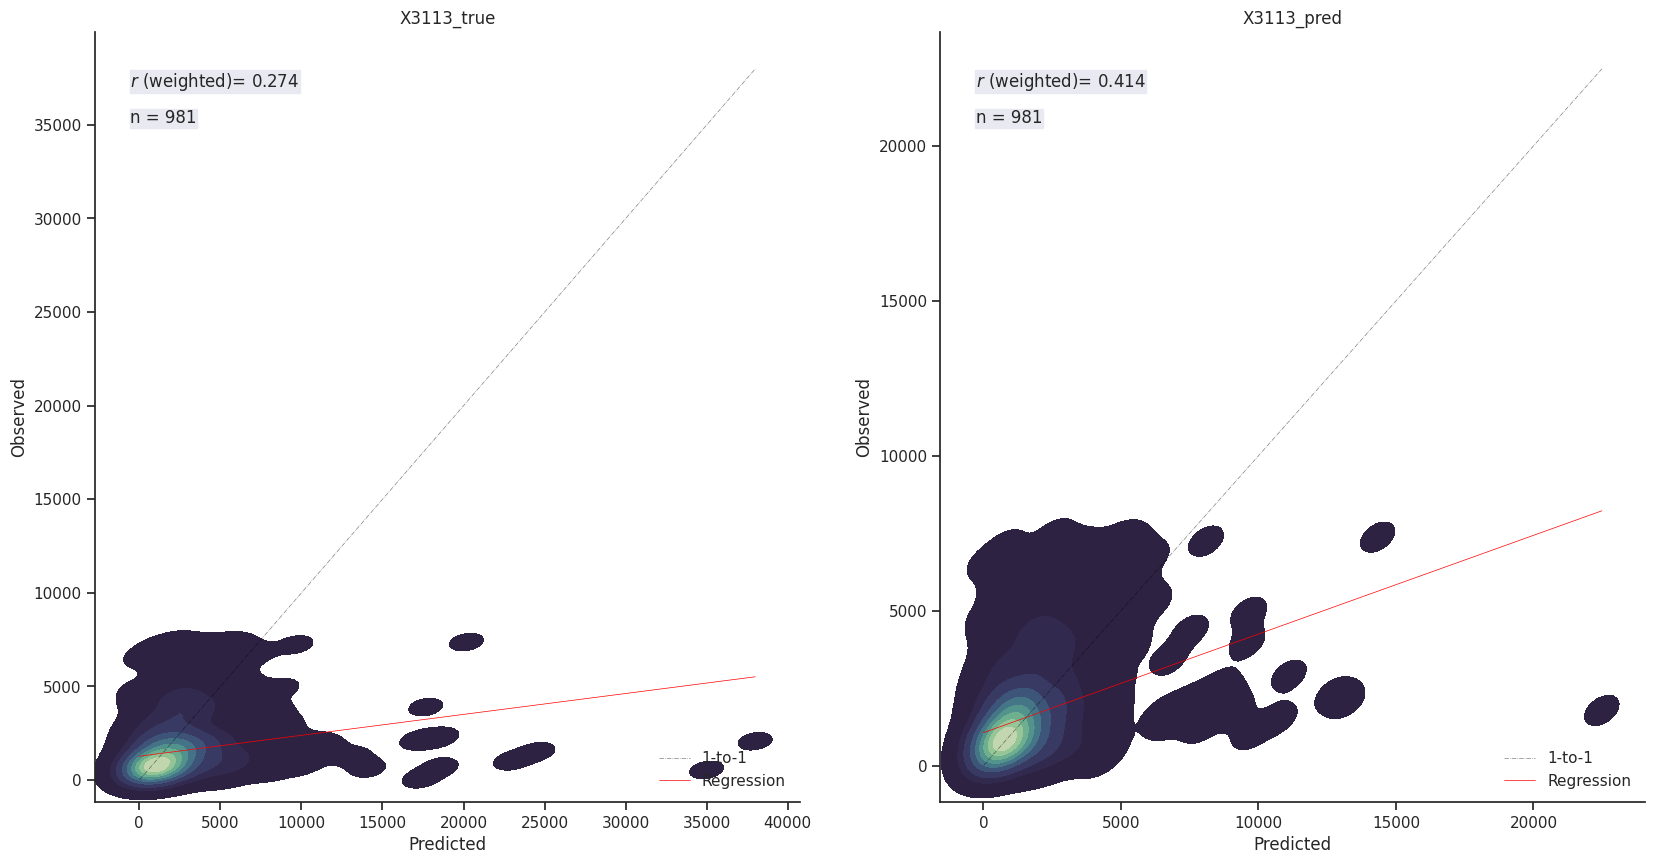

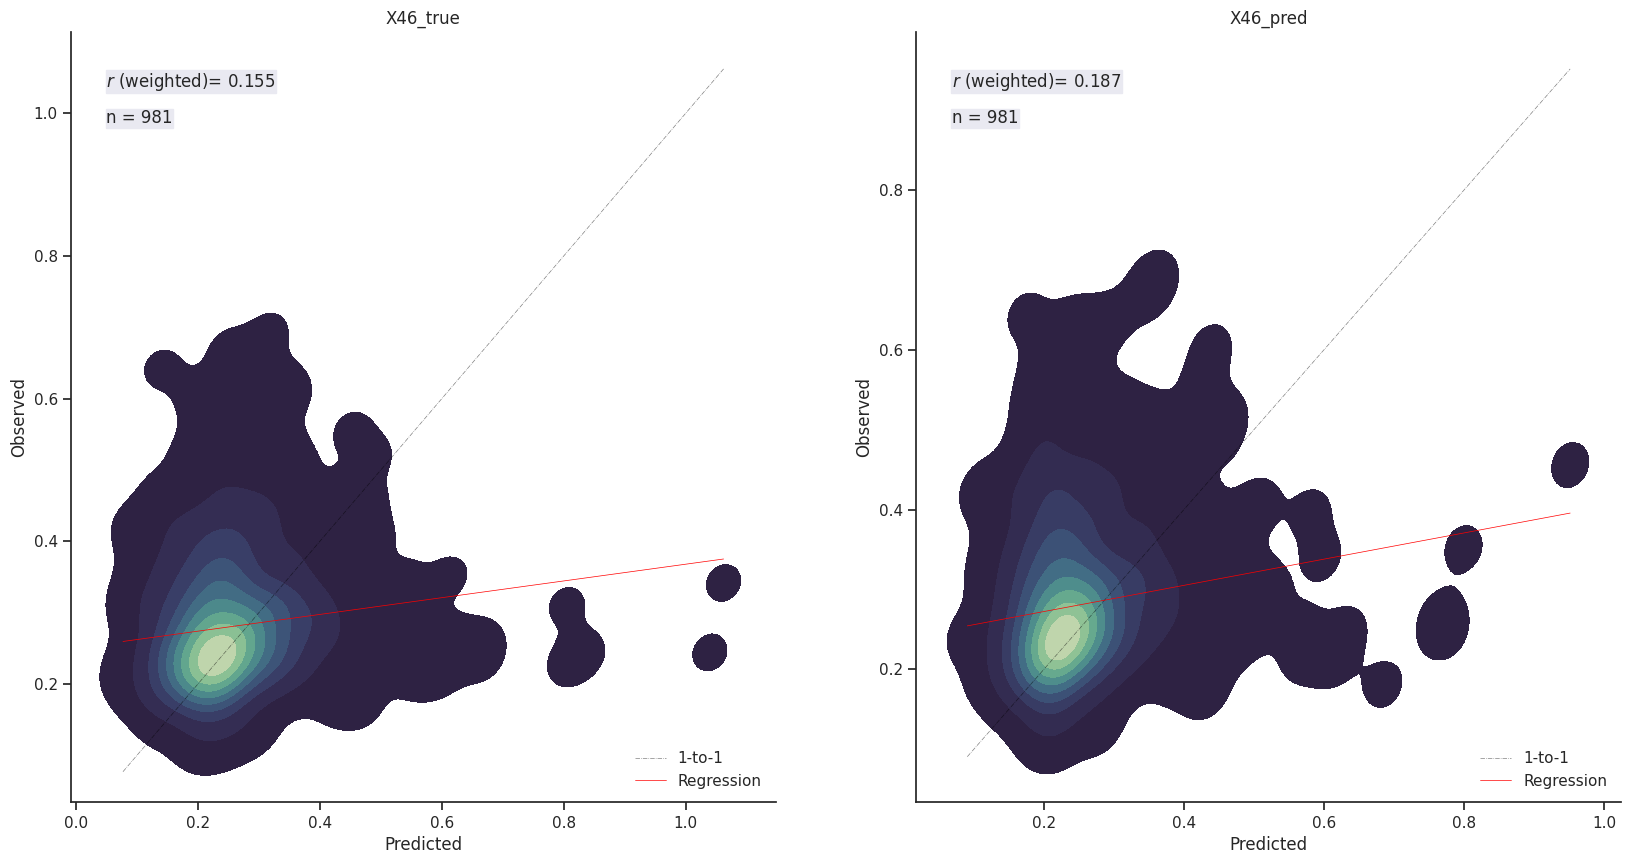

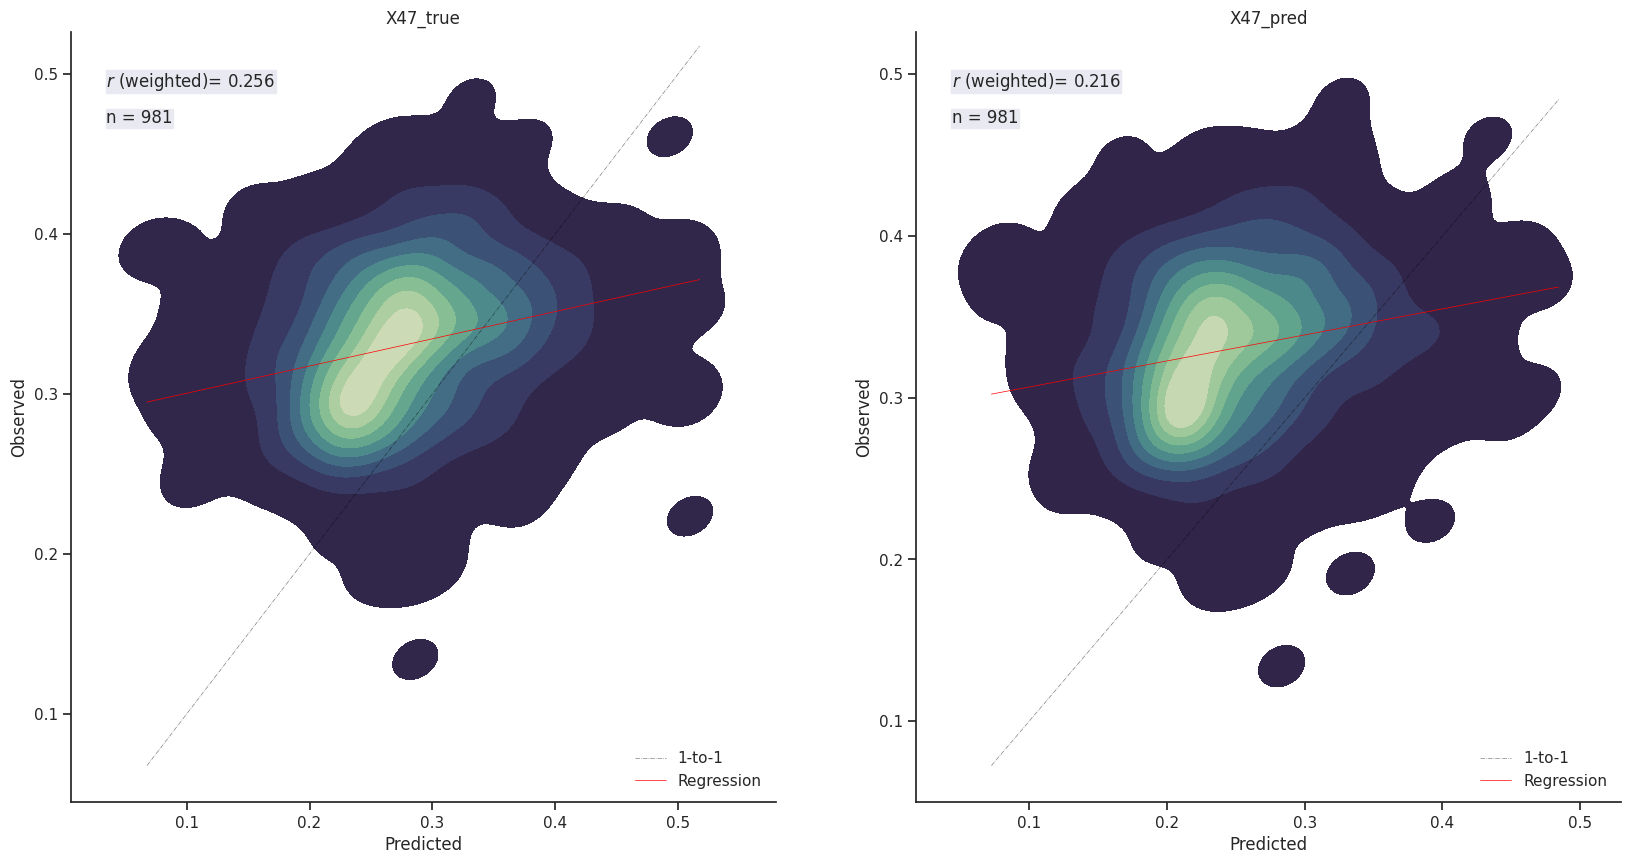

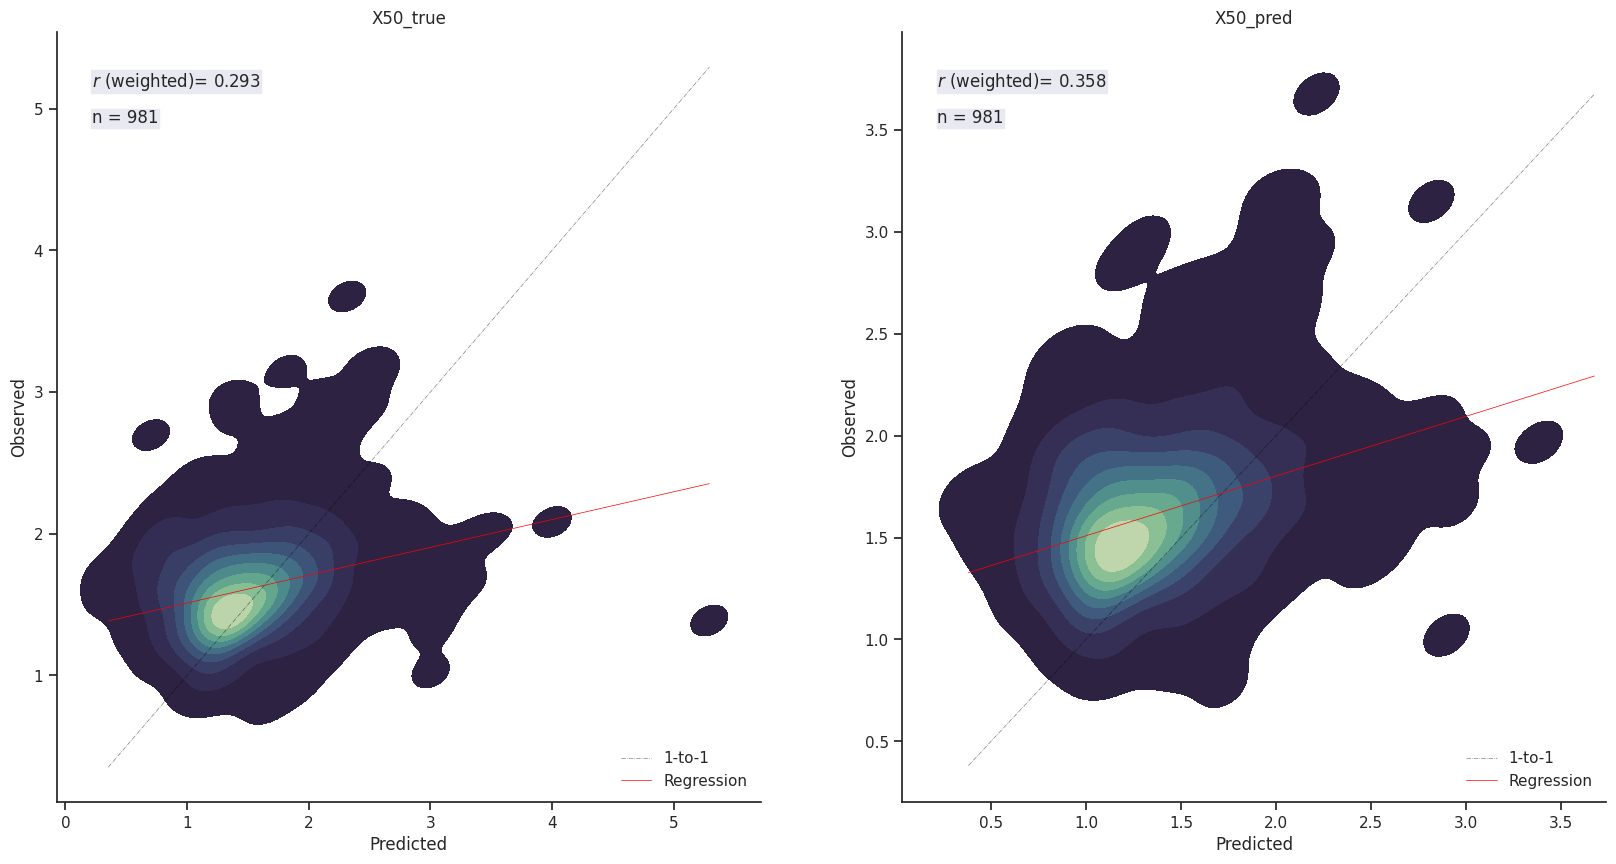

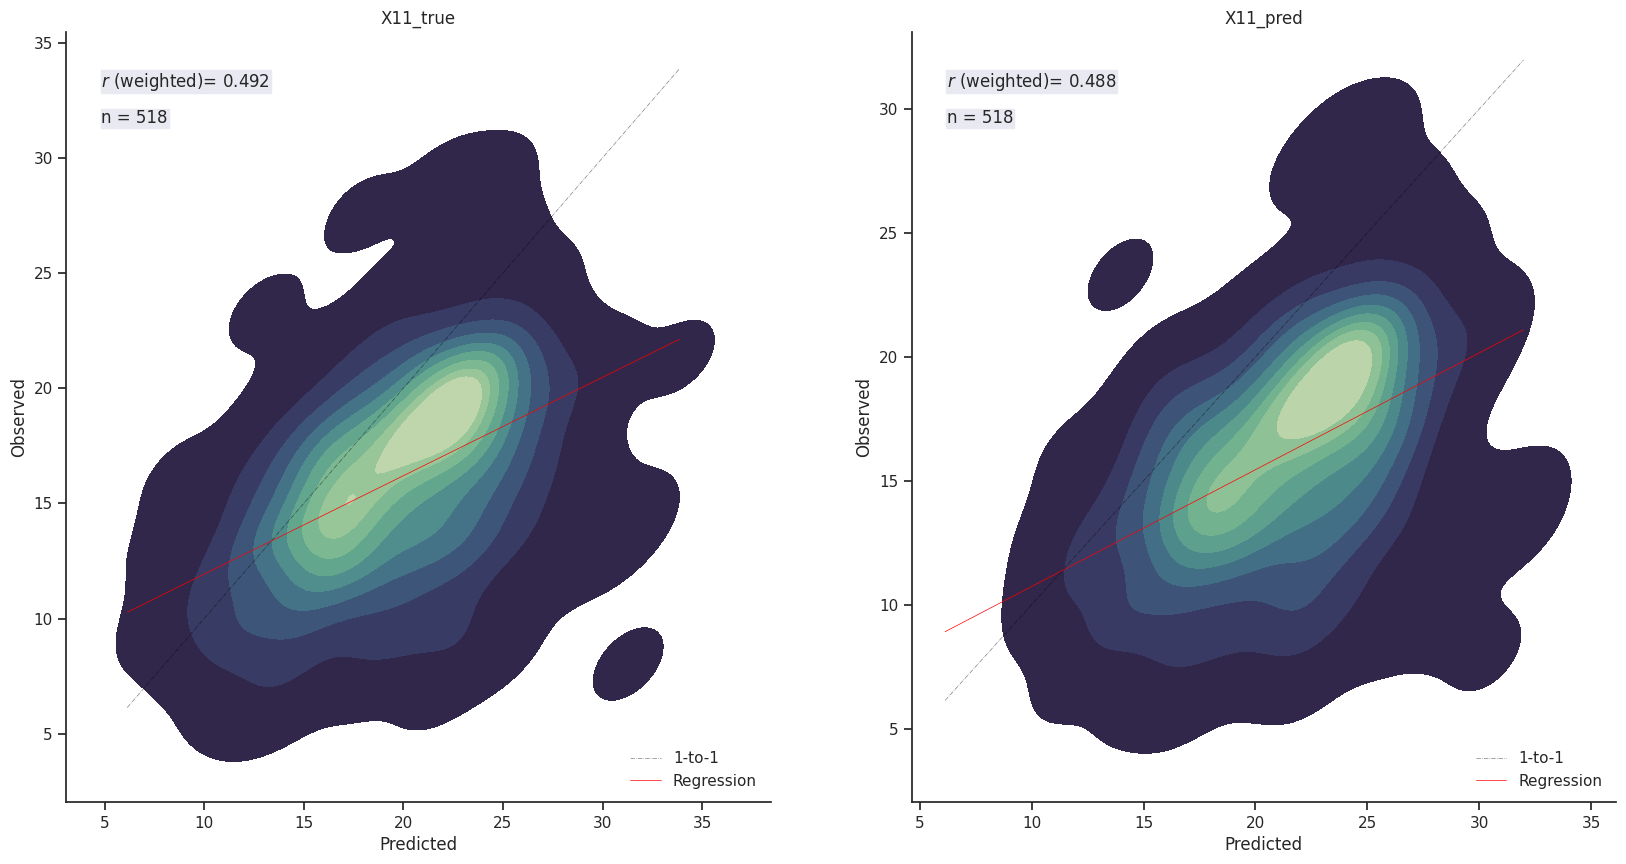

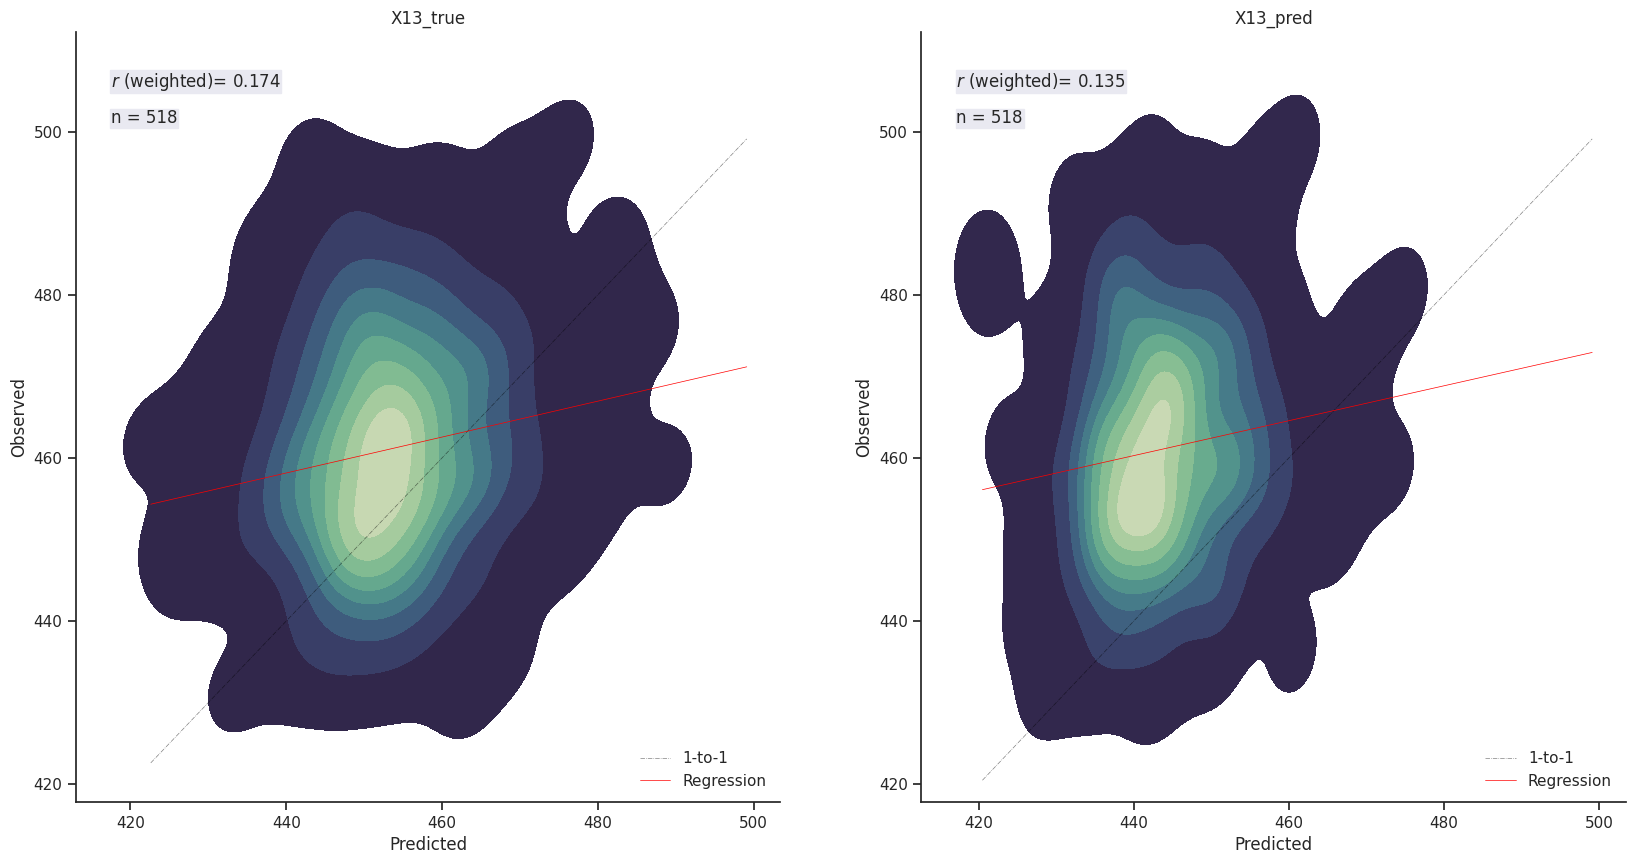

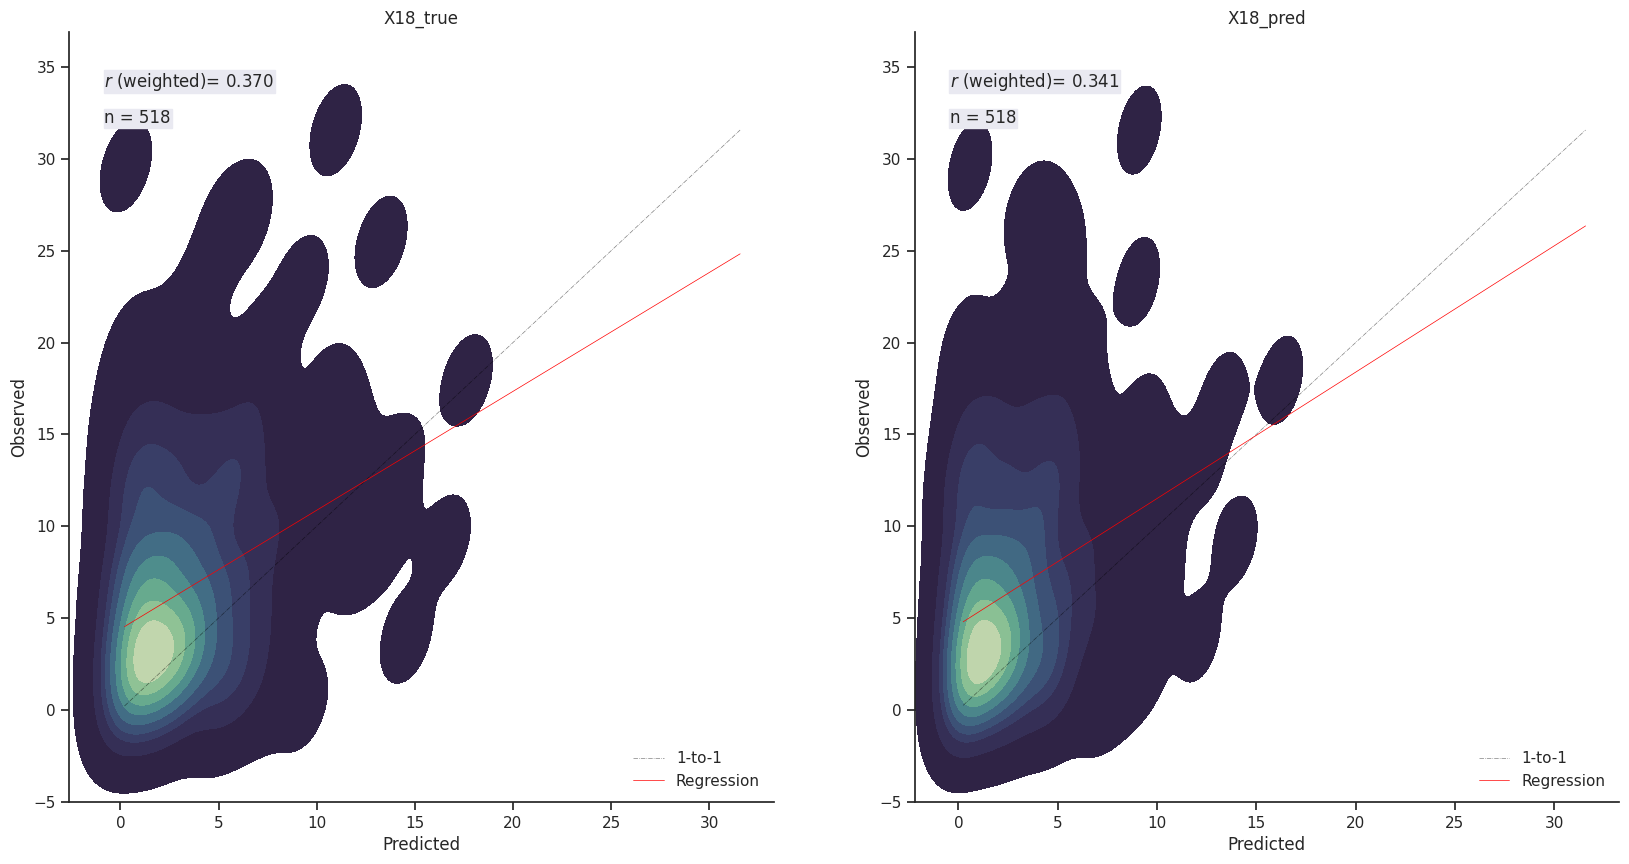

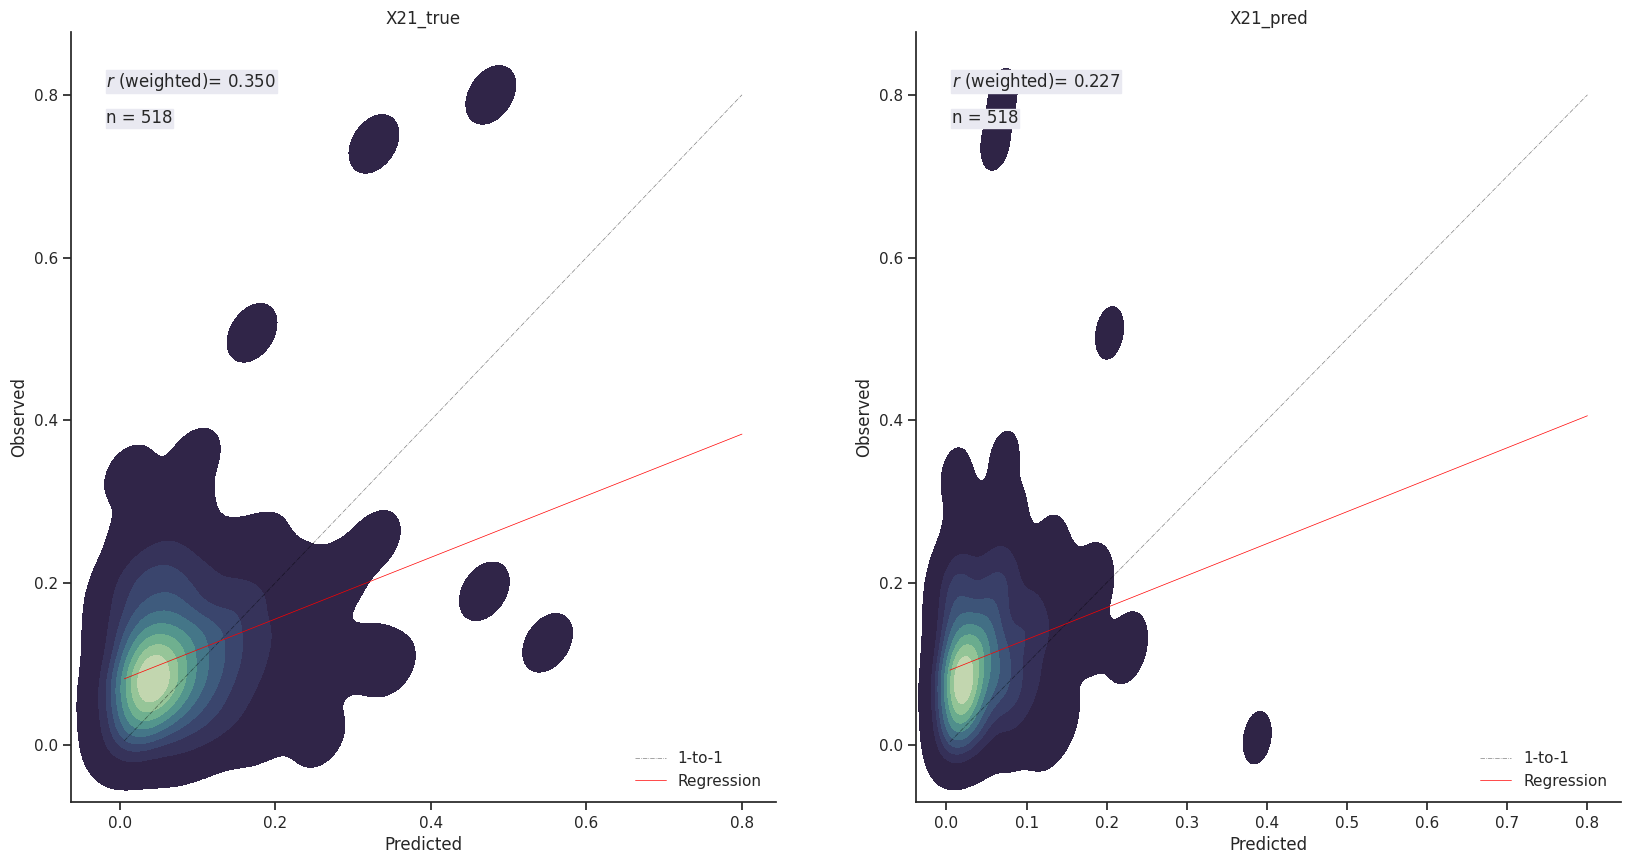

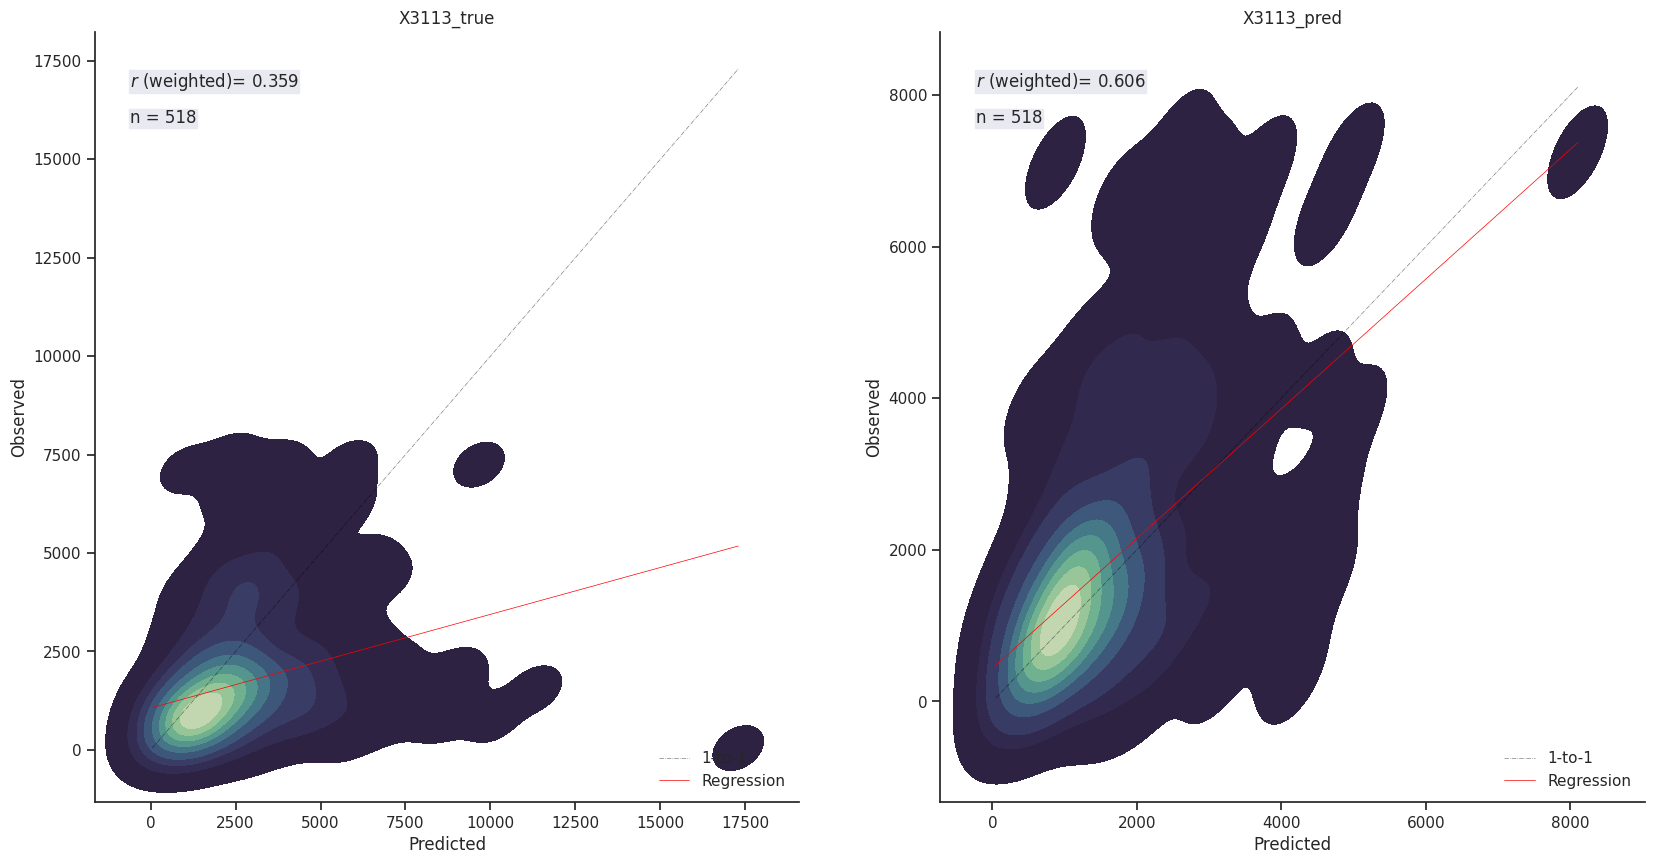

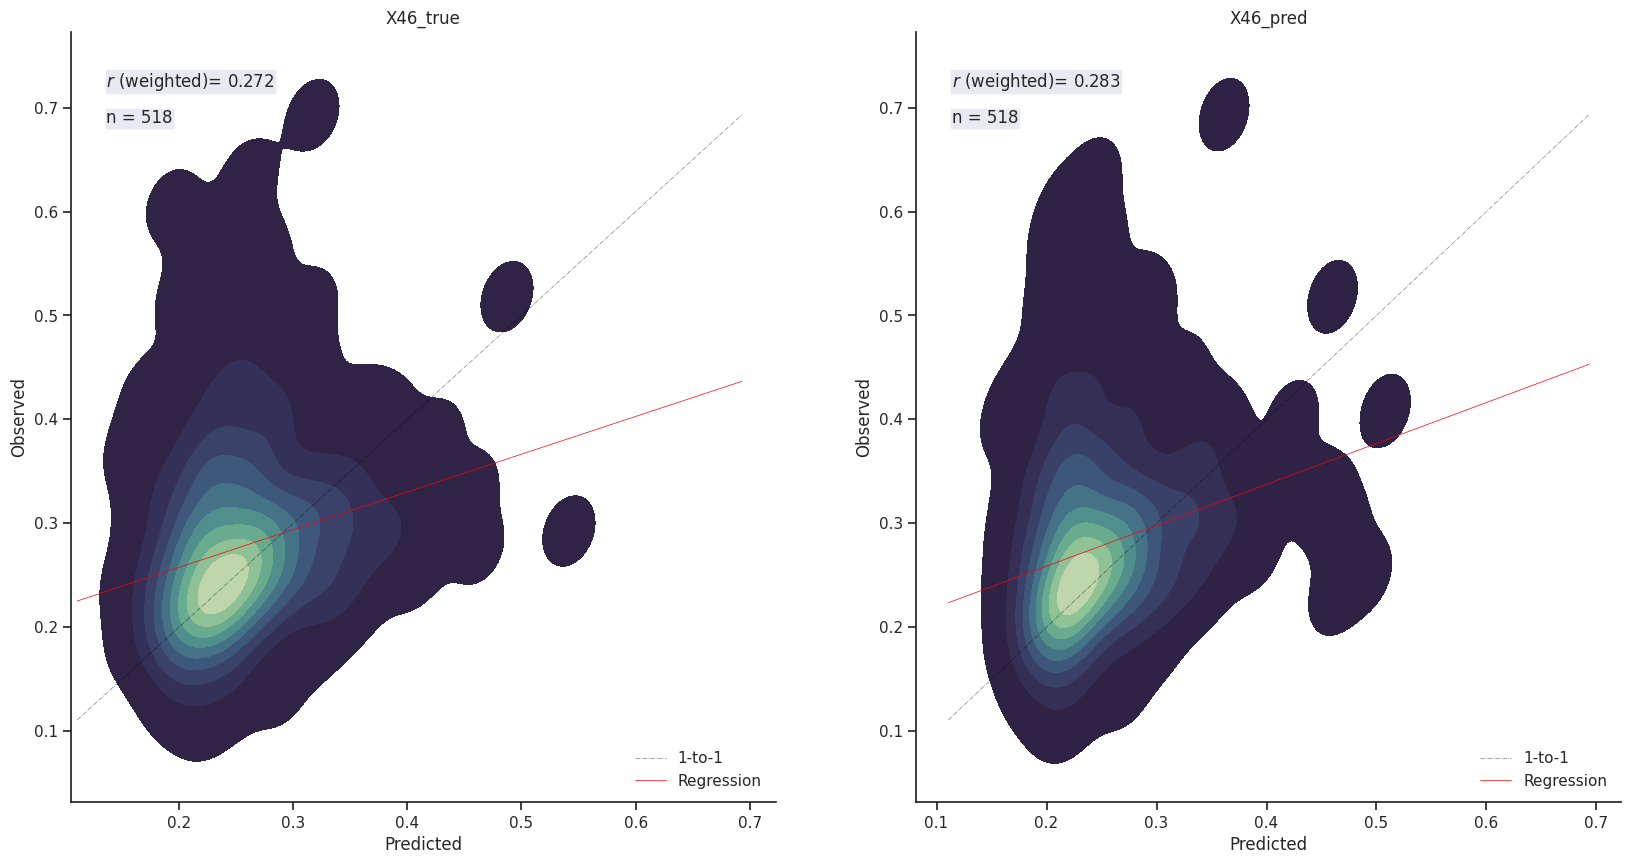

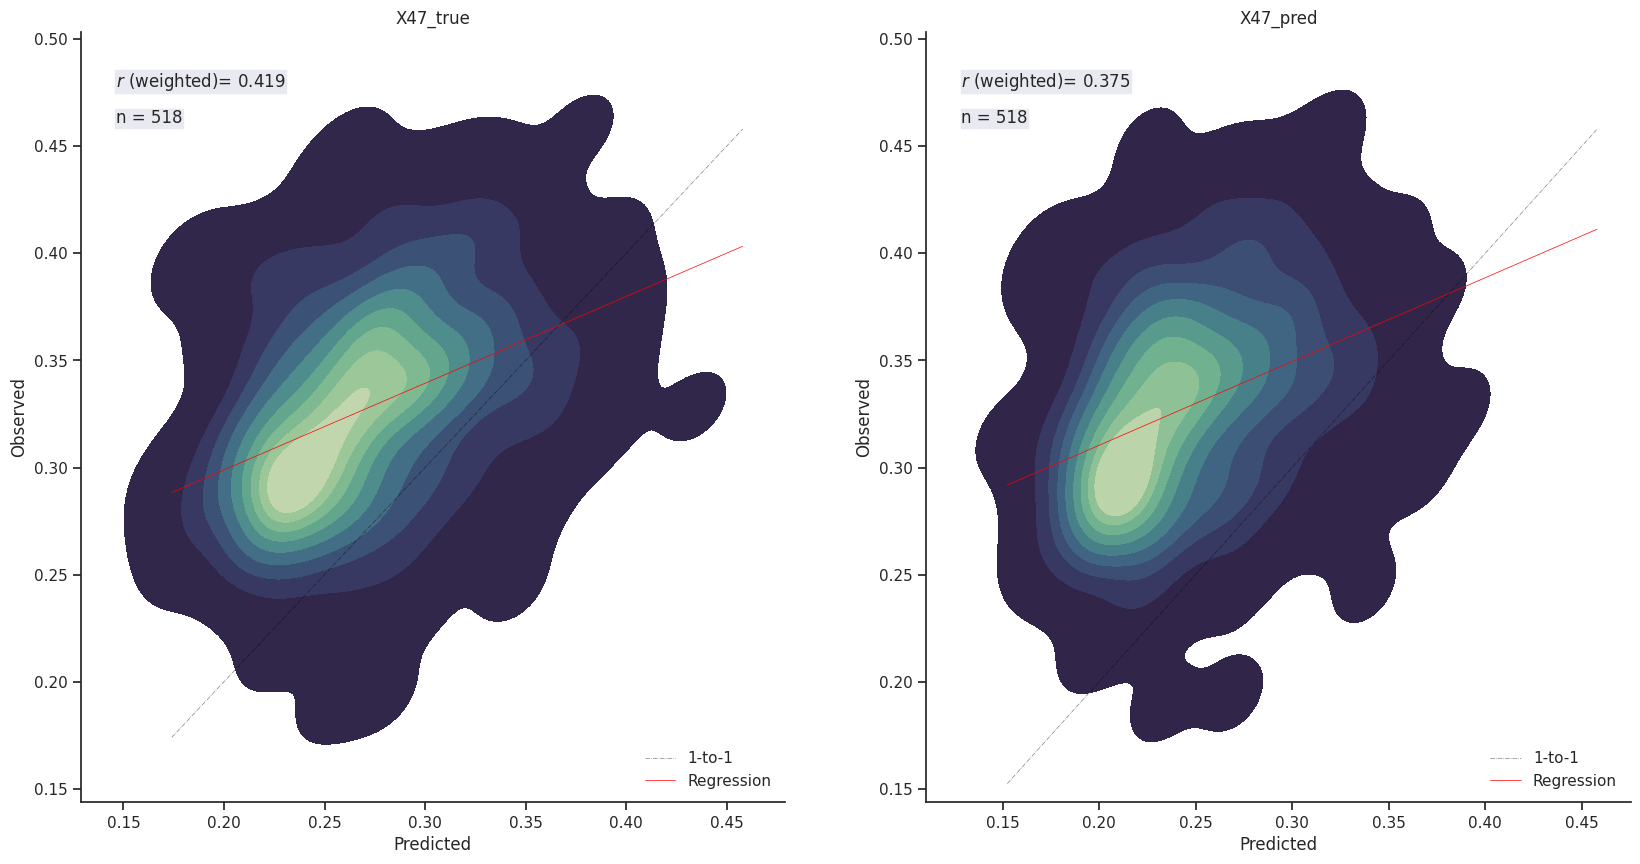

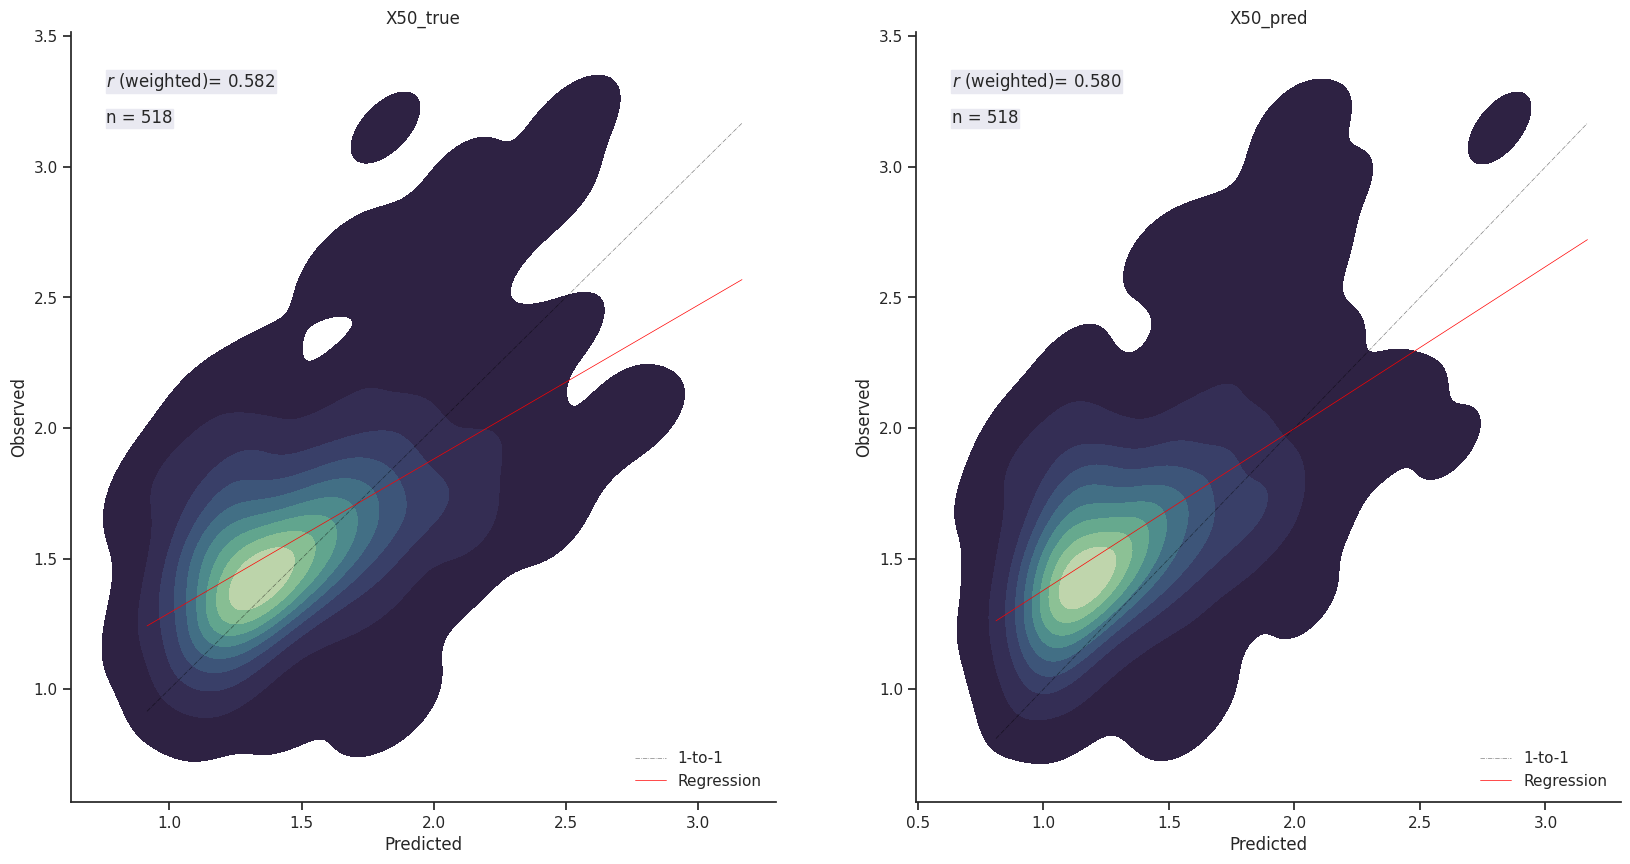

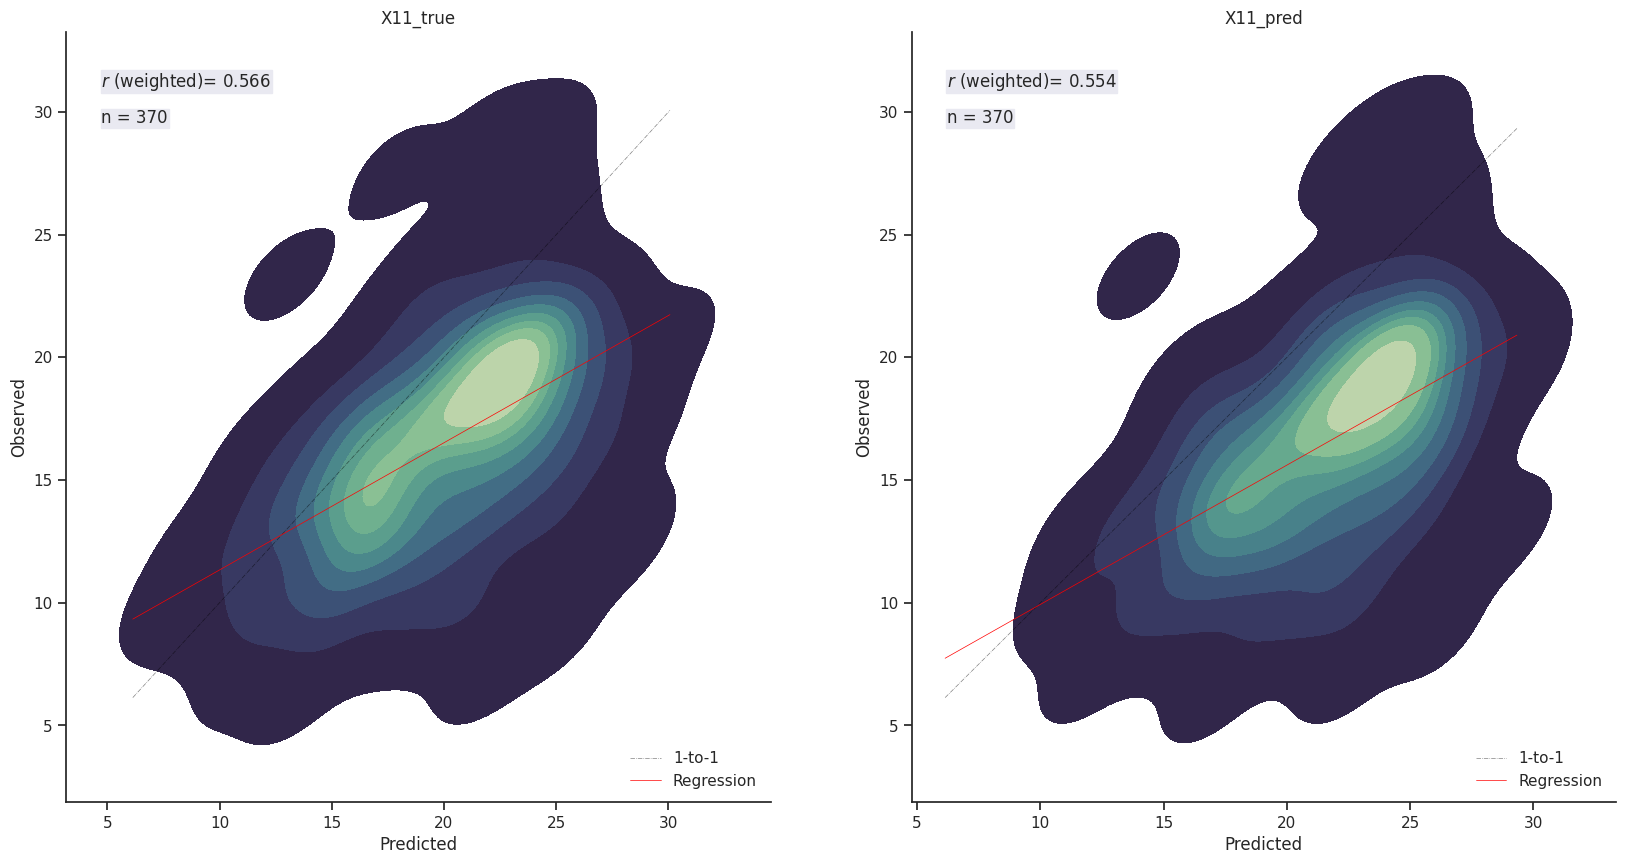

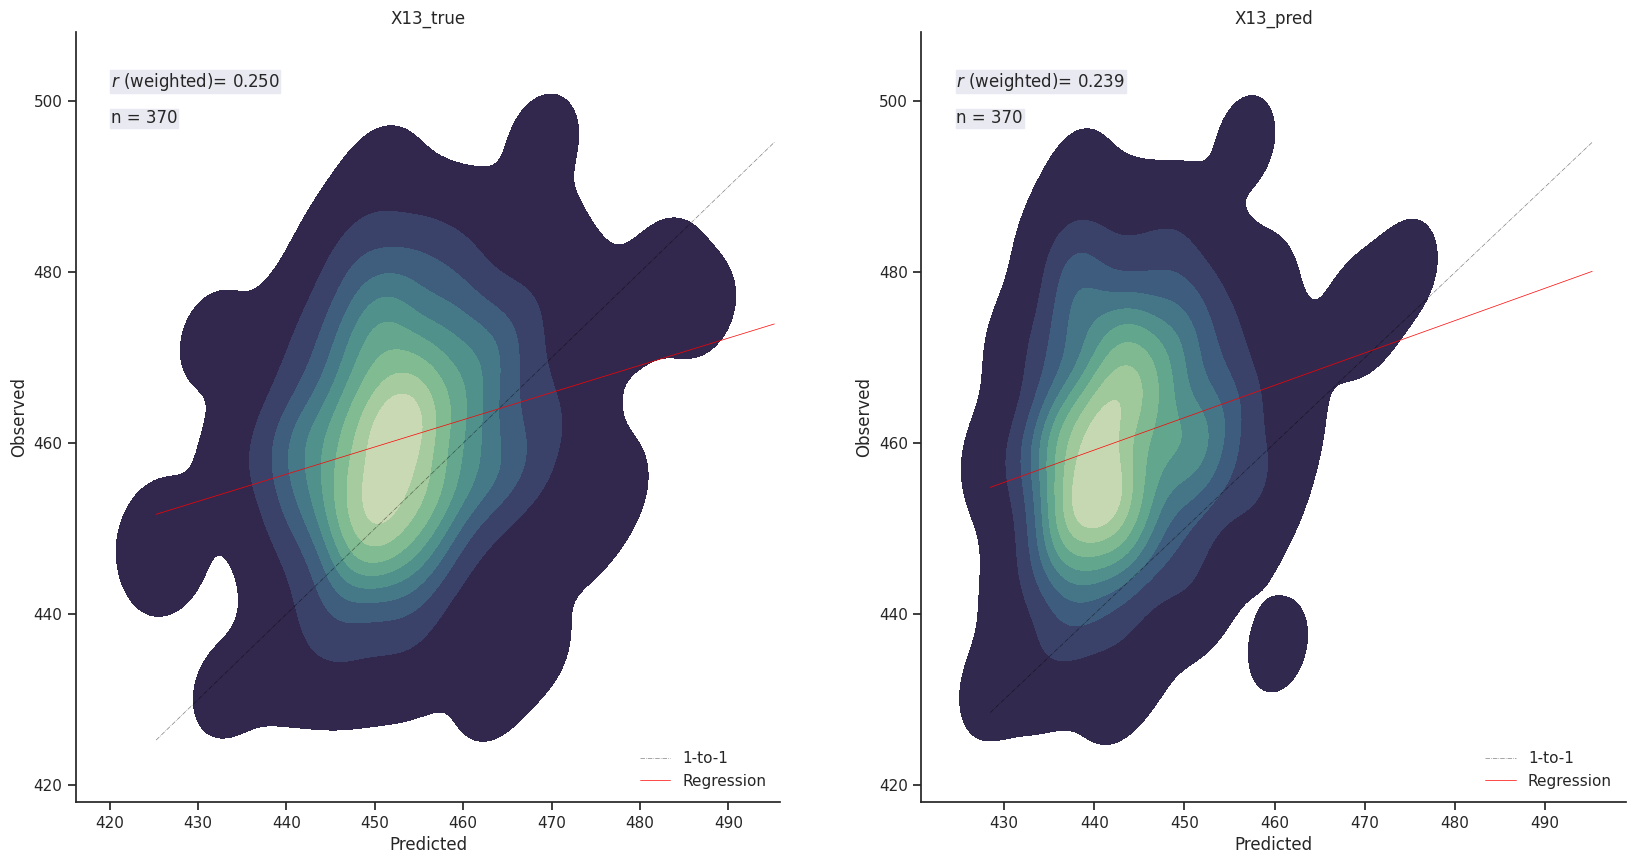

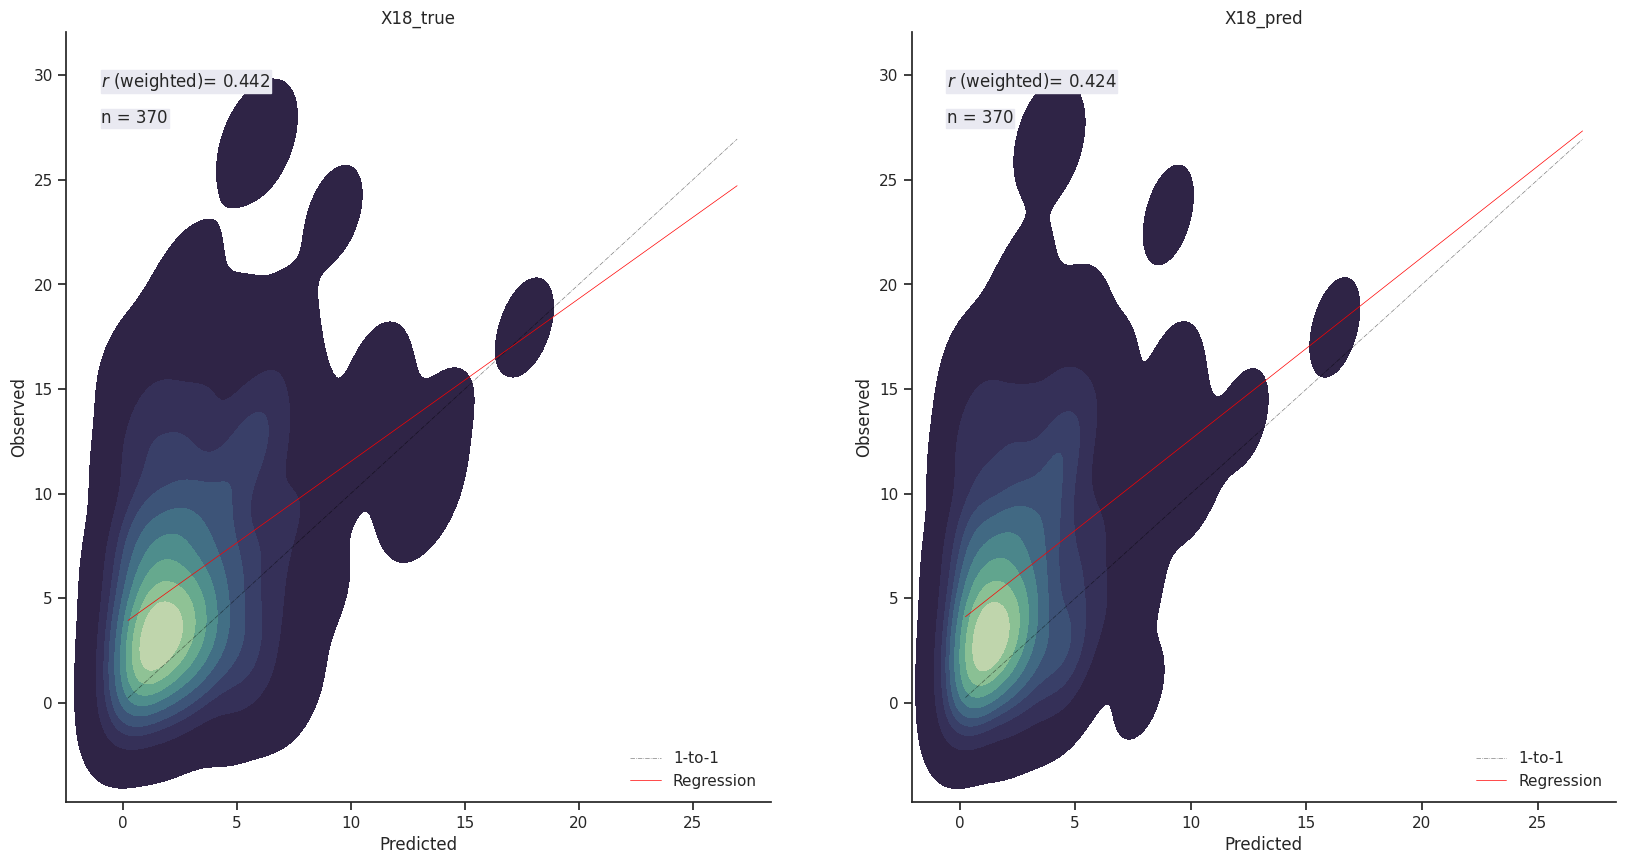

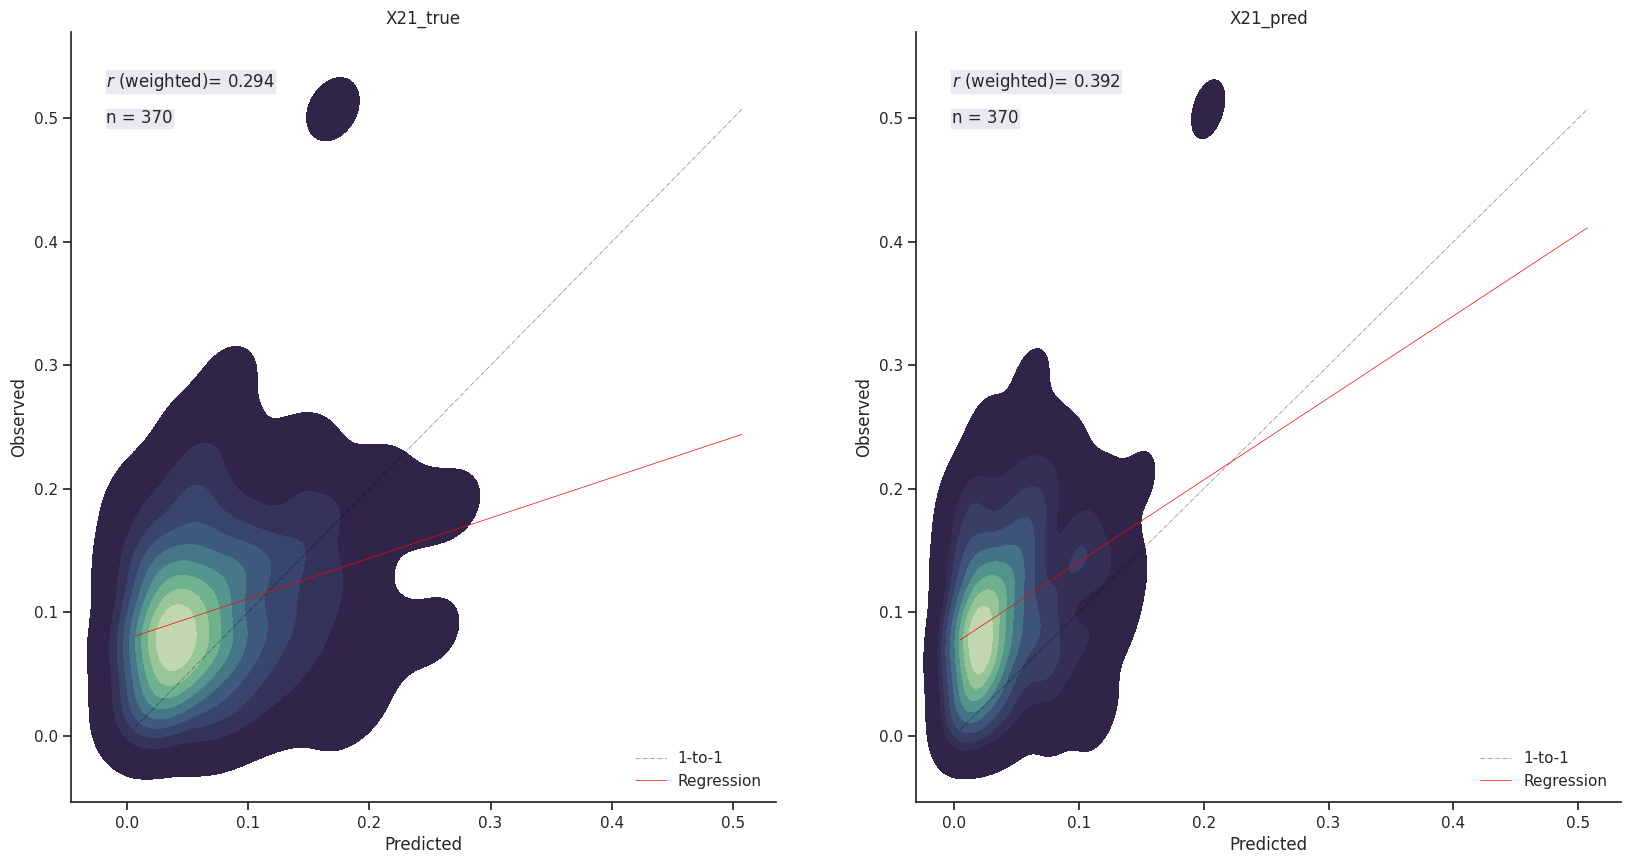

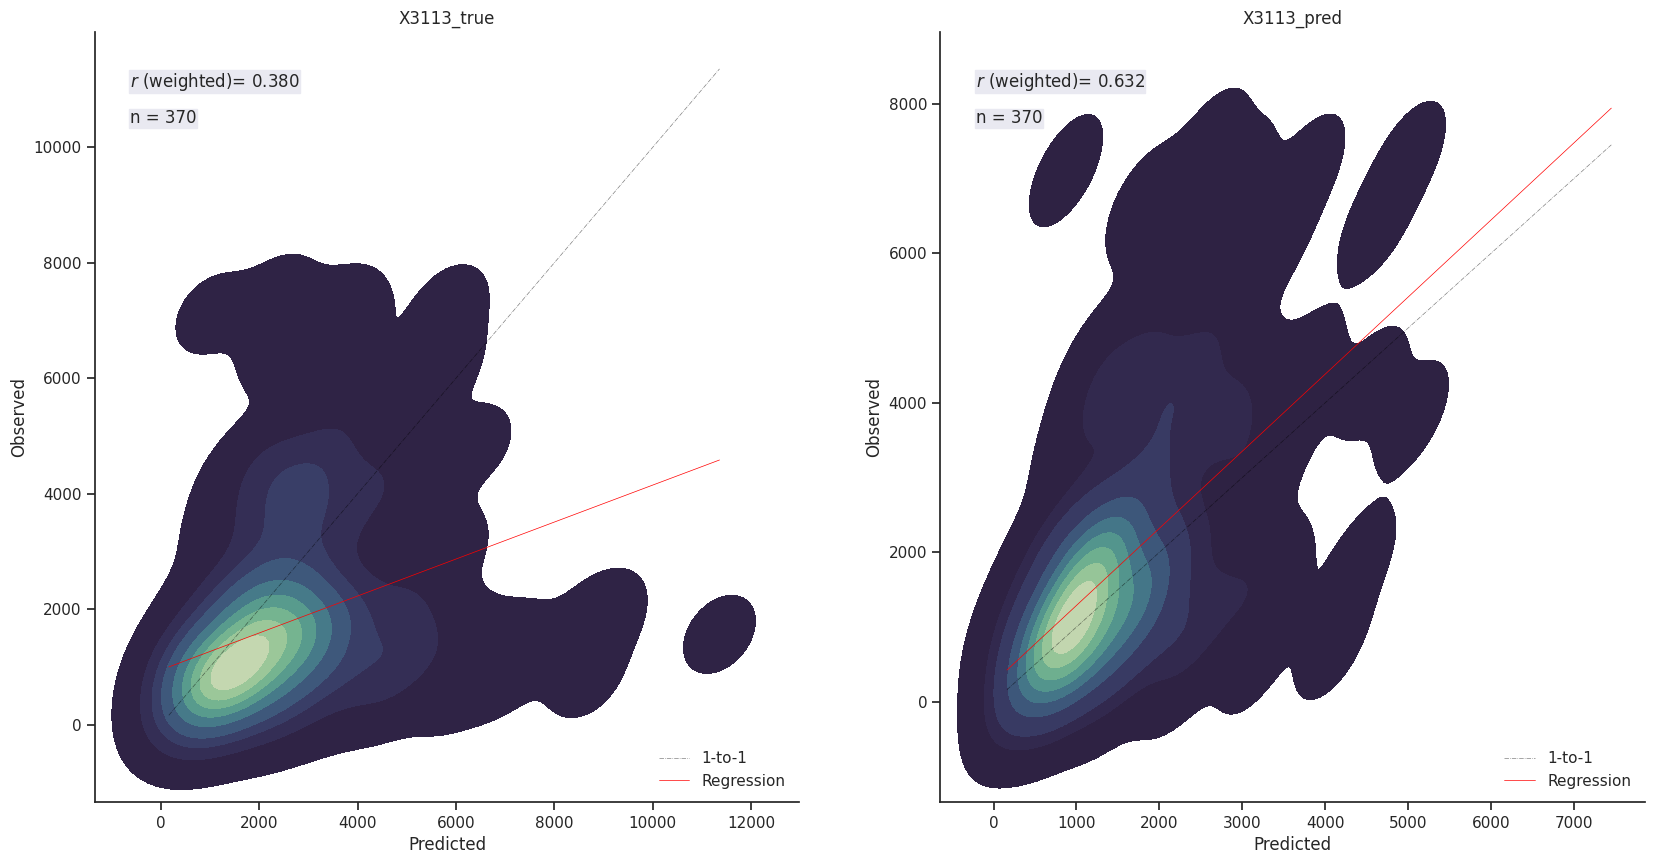

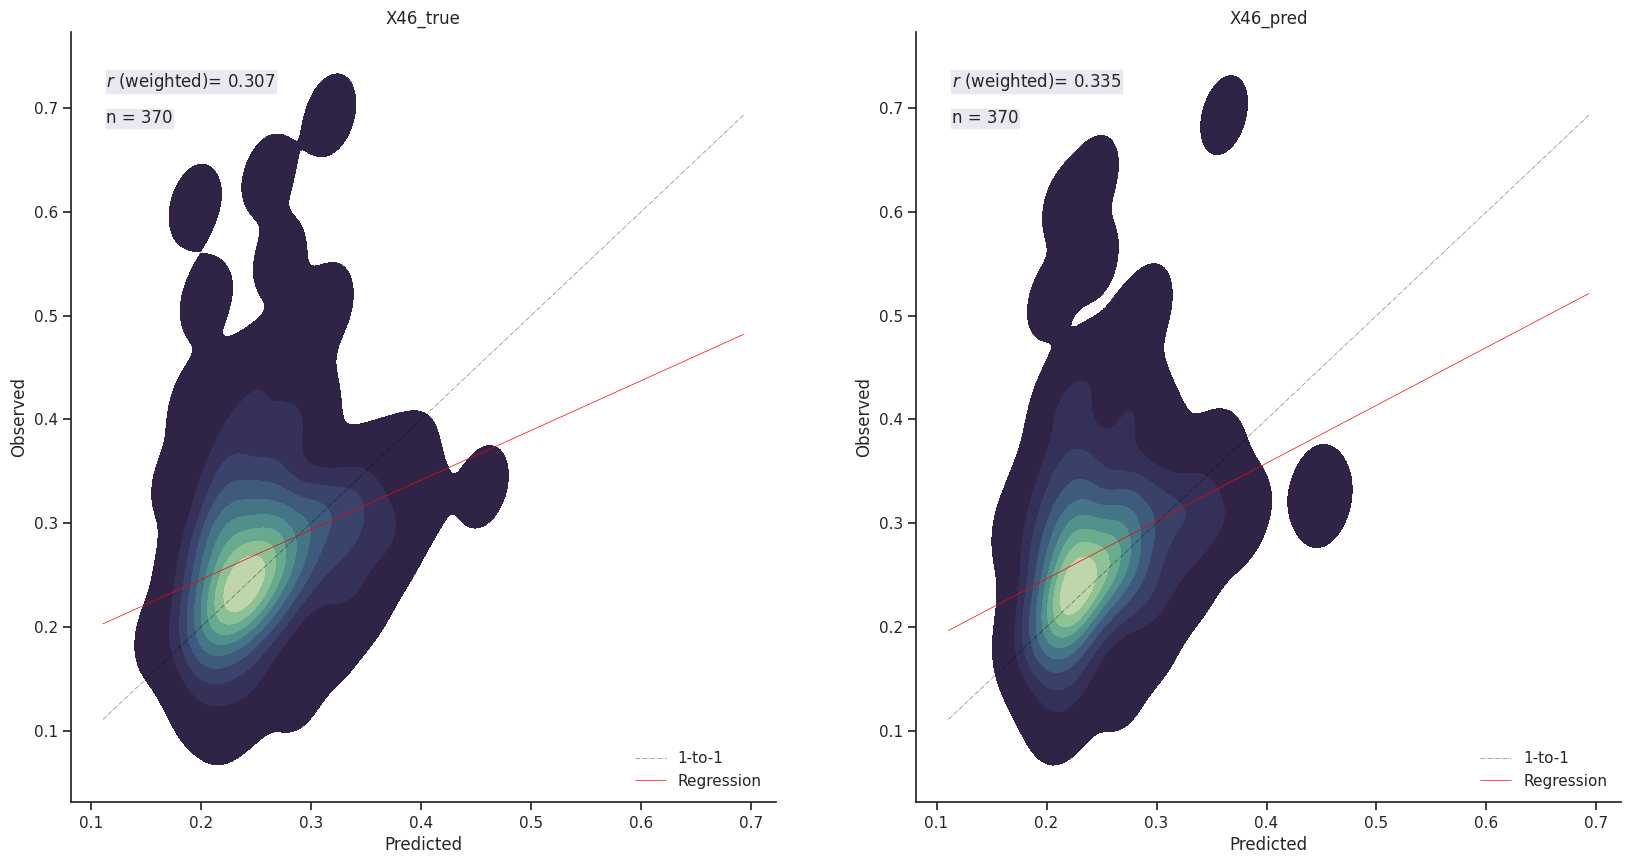

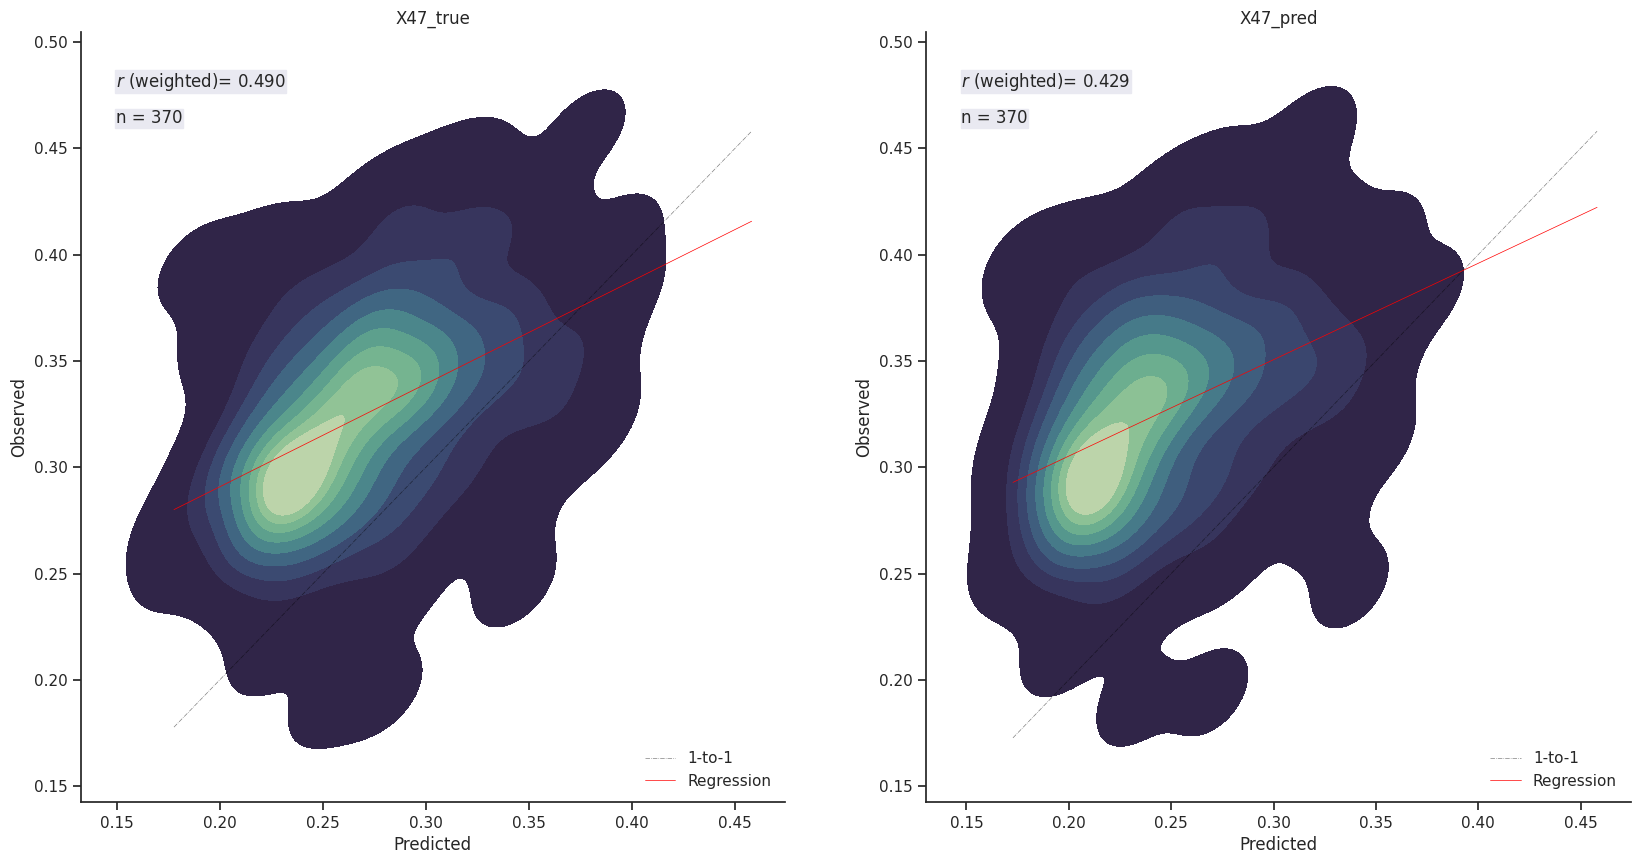

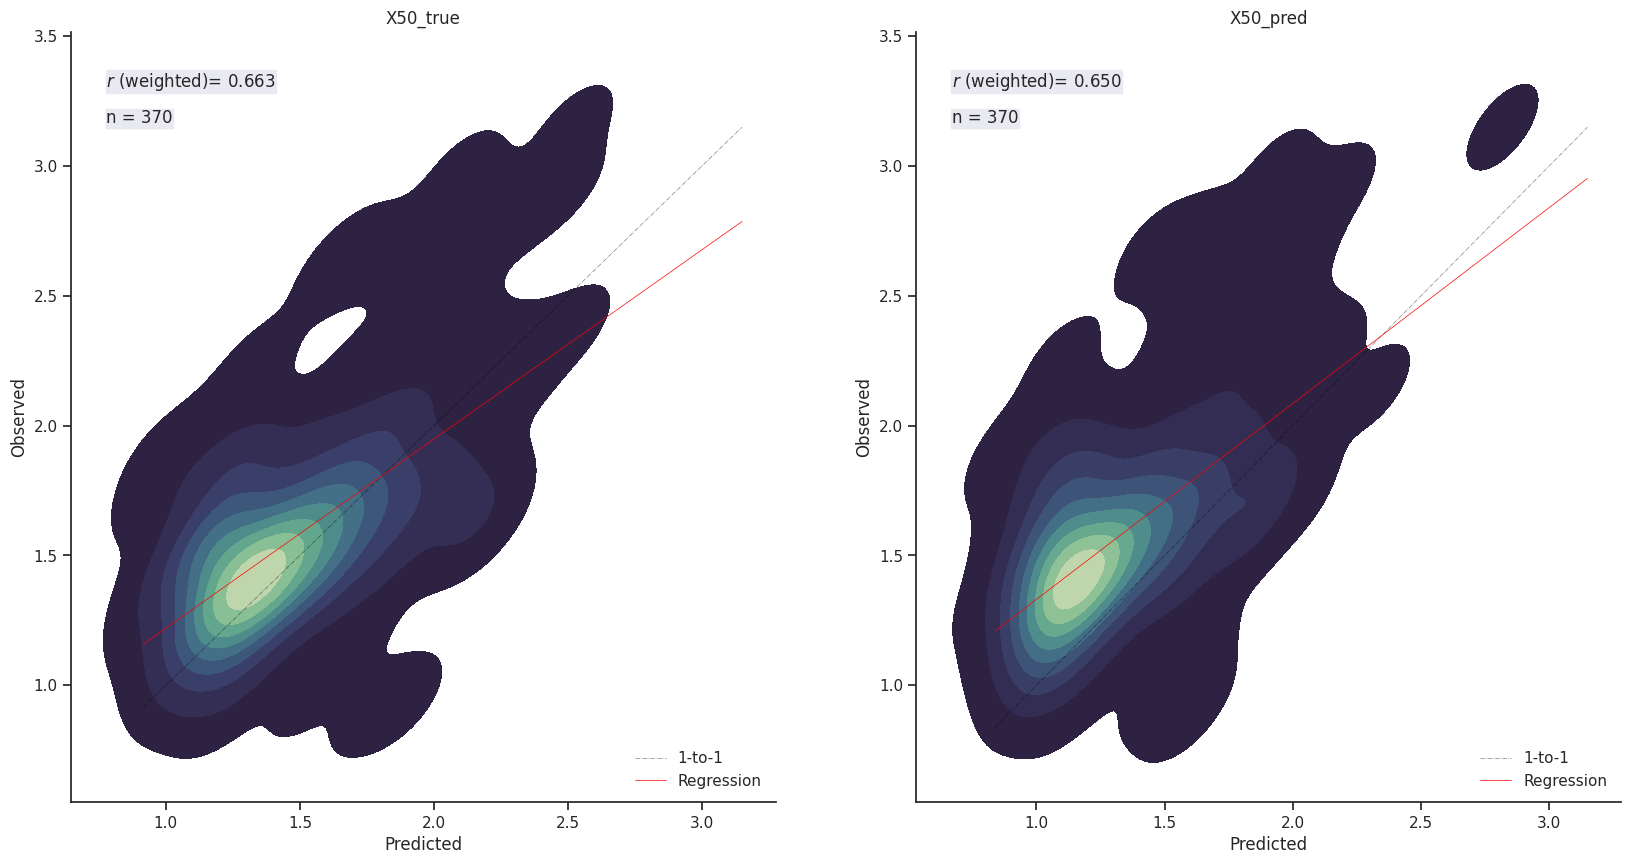

In [3]:
from pathlib import Path
from matplotlib import pyplot as plt
from src.utils.dataset_utils import get_y_fn, read_trait_map
from src.utils.df_utils import global_grid_df
from src.utils.spatial_utils import lat_weights, weighted_pearson_r
from src.visualization.model_assessment import plot_observed_vs_predicted
import seaborn as sns


trait_cols = [col for col in pred.columns if col.startswith("X")]
true_cols = sorted([col for col in trait_cols if col.endswith("true")])
pred_cols = sorted([col for col in trait_cols if col.endswith("pred")])

all_stats_path = Path("share", "sharma", "splot_corr.csv")

if all_stats_path.exists():
    all_stats = pd.read_csv(all_stats_path)
else:
    all_stats = pd.DataFrame(
        {
            "trait": [],
            "source": [],
            "resolution": [],
            "weighted_r": [],
            "r": [],
            "n_min": [],
        }
    )

for n_min in [1, 5, 10]:
    for true_col, pred_col in zip(true_cols, pred_cols):
        trait = true_col.split("_")[0]
        grid_stat = "mean"

        splot_df = (
            read_trait_map(trait, "splot", band=1)
            .to_dataframe(name=trait)
            .drop(columns=["band", "spatial_ref"])
            .dropna()
        )

        true_df = global_grid_df(
            pred[["longitude", "latitude", true_col]],
            true_col,
            lon="longitude",
            lat="latitude",
            res=cfg.target_resolution,
            stats=[grid_stat],
            n_min=n_min,
        ).rename(columns={"mean": true_col})

        pred_df = global_grid_df(
            pred[["longitude", "latitude", pred_col]],
            pred_col,
            lon="longitude",
            lat="latitude",
            res=cfg.target_resolution,
            stats=[grid_stat],
            n_min=n_min,
        ).rename(columns={"mean": pred_col})

        splot_vs_true = true_df.join(splot_df, how="inner").rename(
            columns={trait: "observed", true_col: "predicted"}
        )
        splot_vs_pred = pred_df.join(splot_df, how="inner").rename(
            columns={trait: "observed", pred_col: "predicted"}
        )

        out_dir = Path("share", "sharma")
        combined = pd.concat(
            [
                splot_vs_true.rename(
                    columns={"observed": f"{trait}_splot", "predicted": f"{trait}_true"}
                ),
                splot_vs_pred.rename(columns={"predicted": f"{trait}_pred"})[
                    [f"{trait}_pred"]
                ],
            ],
            axis=1,
        )[[f"{trait}_splot", f"{trait}_true", f"{trait}_pred"]]
        combined_path = (
            out_dir
            / "data"
            / f"{trait}_vs_splot_{cfg.model_res}deg_nmin{n_min}.parquet"
        )
        combined_path.parent.mkdir(parents=True, exist_ok=True)
        combined.reset_index().to_parquet(combined_path)

        # Get unique values of the "y" index
        lat_wts = lat_weights(
            splot_vs_true.index.get_level_values("y").unique().values,
            cfg.target_resolution,
        )
        weighted_r_true = weighted_pearson_r(splot_vs_true, lat_wts)
        r_true = splot_vs_true.corr().loc["observed", "predicted"]
        weighted_r_pred = weighted_pearson_r(splot_vs_pred, lat_wts)
        r_pred = splot_vs_pred.corr().loc["observed", "predicted"]

        trait_stats_true = pd.DataFrame(
            {
                "trait": [true_col.split("_")[0]],
                "source": ["true"],
                "resolution": [cfg.target_resolution],
                "weighted_r": [weighted_r_true],
                "r": [r_true],
                "n_min": [n_min],
            }
        )
        trait_stats_pred = pd.DataFrame(
            {
                "trait": [true_col.split("_")[0]],
                "source": ["pred"],
                "resolution": [cfg.target_resolution],
                "weighted_r": [weighted_r_pred],
                "r": [r_pred],
                "n_min": [n_min],
            }
        )

        all_stats = pd.concat(
            [all_stats, trait_stats_true, trait_stats_pred], ignore_index=True
        ).drop_duplicates()

        with sns.plotting_context("notebook"), sns.axes_style("ticks"):
            fig, ax = plt.subplots(1, 2, figsize=(20, 10))
            ax = ax.flatten()

            ax[0] = plot_observed_vs_predicted(
                ax[0],
                splot_vs_true.observed,
                splot_vs_true.predicted,
                true_col,
                log=False,
                density=True,
                show_r=True,
                manual_r=weighted_r_true,
                r_weighted=True,
            )

            ax[1] = plot_observed_vs_predicted(
                ax[1],
                splot_vs_pred.observed,
                splot_vs_pred.predicted,
                pred_col,
                log=False,
                density=True,
                show_r=True,
                manual_r=weighted_r_pred,
                r_weighted=True,
            )

            sns.despine()

            fig_path = out_dir / "plots" / f"{trait}_vs_splot_{cfg.model_res}deg_nmin{n_min}.png"
            fig_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(fig_path, dpi=300)

    all_stats.to_csv(all_stats_path, index=False)